In [1]:
%load_ext autoreload
%autoreload 2

import os
import pickle
import datetime
import numpy as np
import pandas as pd
import rioxarray as rxr
import statsmodels.api as sm
import matplotlib.pyplot as plt
import polars as pl #libs for faster data processing


from dateutil import tz
import geopandas as gpd

from pyproj import CRS


import sklearn.metrics as metrics
from sklearn.model_selection import  train_test_split
from sklearn.linear_model import LinearRegression


os.chdir('/Users/gaurav/UAH/temperature_modelling/')

#Custom modules
import lib.satellite as sat
import lib.dataprocess as dp 
import lib.crowdqc as cqc
from lib import helper
from lib import modeller as mod
from lib import visualizer
from lib import predictor_oop




#For the issue with .loc[]
pd.options.mode.chained_assignment = None

In [ ]:
#read and segment ec dataset
# ec_data,urb_data, stations_ranges = predictor.get_ec_urban(HOUR_FILTER)


MODEL_PATH    = '/Users/gaurav/UAH/temperature_modelling/Resources/trained_models/'
PREDICTION_DIR =  '/Users/gaurav/UAH/temperature_modelling/Resources/predictions/Madison_2021'

TEST_ECOSTRSS_FILE = '/Users/gaurav/UAH/temperature_modelling/data/raster_op/ECOSTRESS_values_testing.csv'
TEST_URBAN_FILE = '/Users/gaurav/UAH/temperature_modelling/data/raster_op/urban_surface_properties_values_testing.csv'

ec_data =  pd.read_csv(TEST_ECOSTRSS_FILE)
urb_data = pd.read_csv(TEST_URBAN_FILE)

mean_lat_lon = [ec_data.latitude.mean(),ec_data.longitude.mean()]

ec_data = helper.convert_to_gpd(ec_data,'epsg:6879',convert_to='epsg:4326')
urb_data = helper.convert_to_gpd(urb_data,'epsg:6879',convert_to='epsg:4326')
station_ranges = predictor_oop.get_station_ranges(len(ec_data.station.unique()))

In [ ]:
def get_recent(path):
    ''' Function to get the most recent file in a folder'''
    files = os.listdir(path)
    files_sorted_by_creation_time = sorted(files, key=lambda f: os.path.getctime(os.path.join(path, f)))
    files_sorted_by_creation_time = [f for f in files_sorted_by_creation_time if 'DS_Store' not in f and 'saved' not in f]
    return files_sorted_by_creation_time[-1]


In [ ]:
from sklearn.preprocessing import StandardScaler

window_size = 5
#Its here because I don't want to pass final_df everytime
def get_partitions(final_df,col_list,selection_hour,scaler=False):
    ''' Get final split of data based on hour selected
        selection_hour = [1] or None
    '''
    final_df_x = final_df.query(f'hour == {list([selection_hour or list(np.arange(0,24,1))][0])}')
    X_train, X_test, y_train, y_test = mod.get_train_test_data(final_df_x,window_size,shuffle=True)
    hour_status = final_df_x.hour.unique()

    d_train, d_test = X_train[col_list], X_test[col_list]

    #if there is no hour column, then its set to none, such that the plotter function behaves accordingly
    # hour_status = True if 'hour' in d_train.columns else False

    if scaler:
        scaler = StandardScaler()

        d_train =  scaler.fit_transform(d_train)
        d_train = pd.DataFrame(d_train,columns=col_list)
        d_test = scaler.transform(d_test)
        d_test = pd.DataFrame(d_test,columns=col_list)

    return [d_train, d_test, y_train, y_test], hour_status


def bulk_model_runner(model,grouped_data,col_list,delete=True,bulk_mode=True,fit = True,residuals=False):
    ''' This function runs the model for all hours and saves the predictions and error
        grouped_data = data grouped by station
        col_list = columns to be used for modelling
        delete = True if you want to delete the contents of directory
        bulk_mode = True if you want to train one model for each hour
        fit = True if you want to fit the model, False if you want to load the model
            will be used for transfer learning
    '''

    #cleaning the directory first
    model_name = model.__class__.__name__
    model_path = os.path.join(mod.MODEL_PATH,model_name)
    if delete:
        helper.clean_directory(model_path)

    new_grouped_data = grouped_data.copy()

    if residuals:
        #group the grouped data by hour to find hourly mean and subtract it from the temperature
        print('Residuals are being subtracted from data')
        new_grouped_data['delta_temp'] = new_grouped_data['temperature']-new_grouped_data.groupby('hour')['temperature'].transform('mean')
        new_grouped_data['old_temperature'] = new_grouped_data['temperature']
        new_grouped_data['temperature'] = new_grouped_data['delta_temp']
        hour_lookup = new_grouped_data.groupby('hour')['old_temperature'].mean().reset_index()

        hour_lookup.to_csv('Analytics/temp_data/hour_lookup.csv',index=False)
        print('Hour lookup saved in Analytics/temp_data/hour_lookup.csv')

    model_dict = {}
    model_output_dict = {}
    if bulk_mode:
        feature_importances_dict = dict()
        for hour_ in range(24):
            data,hour_status = get_partitions(new_grouped_data,col_list,[hour_])  #or None
            predictions,error = mod.train_save(model, data, hour_status)
            try:
                feature_importances = model.feature_importances_
            except:
                feature_importances = None
            model_dict[hour_] = [predictions,error,feature_importances]

        for hour in model_dict.keys():
            feature_importances_dict[hour] = model_dict[hour][2]
            model_dict[hour][0]['hourly_rms'] = model_dict[hour][1]

        hour0 = model_dict[0][0]

        for hour in model_dict.keys():
            if hour != 0:
                hour0 = pd.concat([hour0,model_dict[hour][0]],axis=0)

        model_output_dict['hourly_values'] = hour0
        model_output_dict['feature_importances'] = pd.DataFrame(feature_importances_dict).mean(axis=1).values

        
        
    
    if not bulk_mode:
        data,hour_status = get_partitions(new_grouped_data,col_list,None)
        predictions,error = mod.train_save(model, data, hour_status)
        try:
            feature_importances = model.feature_importances_
        except:
            feature_importances = None
        model_dict['hourly_values'] = [predictions,error,feature_importances]

        #new module to uniformly output data
        combined_df = model_dict['hourly_values'][0]
        hourly_rmse = combined_df.groupby('hour').apply(lambda x : metrics.mean_squared_error(x.predicted_temperature,x.true_temperature,squared=False)).reset_index(name='hourly_rms')
        combined_df = pd.merge(combined_df, hourly_rmse, on='hour')

        model_output_dict['hourly_values'] = combined_df
        model_output_dict['feature_importances'] = model_dict['hourly_values'][2]

    if residuals:
        print('Residuals are being added back to the predictions')
        predictions = model_output_dict['hourly_values']

        model_dict_updated = predictions.merge(hour_lookup,on='hour')
        model_dict_updated['predicted_temperature'] = model_dict_updated['predicted_temperature']+model_dict_updated['old_temperature']
        model_dict_updated['true_temperature'] = model_dict_updated['true_temperature']+model_dict_updated['old_temperature']

        model_output_dict['hourly_values'] = model_dict_updated
    
        
    return model_output_dict

def find_frequent(outliers_dict,number=6):
    hash_map = dict()
    hash_map_tree = dict()

    for hrs in outliers_dict.keys():
        val = outliers_dict[hrs]
        for v in val:
            hash_map[v] = 1 + hash_map.get(v,0)
            hash_map_tree[v] = 1 + hash_map_tree.get(v,0)

    hash_map_tree = {k: v for k, v in sorted(hash_map_tree.items(), key=lambda item: item[1],reverse=True)}
    top_n = {k:v for k,v in sorted(hash_map_tree.items(),key=lambda x: x[1],reverse=True)[:number]}
    return top_n

def combine_hashes(hash1,hash2):
    for k,v in hash2.items():
        hash1[k] = 1 + hash1.get(k,0)
    return hash1

In [ ]:
grouped_data = pd.read_csv('Analytics/temp_data/grouped_data_untouched.csv')
grouped_data


In [ ]:
def combine_results(global_dict1,global_dict2,cmap='coolwarm'):
    for items in global_dict2.keys():
        if items != 'bound' and items != 'test_column_list':
            data =(global_dict1[items][0]+ global_dict2[items][0])/2
            visualizer.get_plot(data,global_dict2['bound'], cmap =cmap,change_null=True,plot_boundary=True,hour=items,model_name=predictor.model.__class__.__name__,dpi=600,save=False)
            # visualizer.get_plot(global_dict2[items][1],global_dict2['bound'], cmap = 'plasma',change_null=True,plot_boundary=True,hour=items,model_name=predictor.model.__class__.__name__,dpi=600,save=False)
    # return data

#### LR = 0.01 , L2 = 1, L1 = 0.5

In [ ]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats


col_list = [
    # 'latitude', 'longitude', 
            'hour', 
            'closest_station_1_temp',
          # 'closest_1_distance',
      #  'day_of_year', 
       'adjusted_lst',
       'valueImperviousfraction', 'valueTreefraction', 'valueBuildingheight',
      #  'valueNearestDistWater',
         'valueWaterfraction', 'valueBuildingfraction',
        #   'horizontal_wind','vertical_wind'
          ]

# Define the hyperparameter distributions
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    # 'eta': 0.01,  # Learning rate (shrinkage)
    'eta': 0.15,  # Learning rate (shrinkage)
    # 'max_depth': 5,
    'lambda': 1,  # L2 regularization term
    'alpha': 0.5,  # L1 regularization term
}

xgb_model = xgb.XGBRegressor(**params)
# xgb_model = xgb.XGBRegressor()


model_dict = bulk_model_runner(xgb_model,grouped_data,col_list,bulk_mode=False,delete=True,residuals=True)
visualizer.plot_mean(model_dict,'XGB',col_list)


In [ ]:
hour_ranges = [1,3,10,12,15,20,22]


In [ ]:
wind_status = False
recent_folder = get_recent(MODEL_PATH)
model_name = get_recent(os.path.join(MODEL_PATH,recent_folder))
print(model_name)
global_dict = {}


# hour_ranges = [0,8,10,11,20]
hour_ranges = [3,10,12,20]
# hour_ranges = [0,10,20]

# hour_ranges = range(0,20)


# Defining predictor 
for hour in hour_ranges:
    predictor = predictor_oop.Predictor(model_name,hour_filter=[hour],wind_data=wind_status)
    #setting ec_data for this predictor to be only for that hour
    ec_segment = predictor.set_ec_segments(ec_data)
    runner_op = predictor.runner(urb_data,station_ranges)

    global_dict[hour] = runner_op[0]

global_dict['bound'] = runner_op[1]
global_dict['test_column_list'] = runner_op[2]

hour_map = pd.read_csv('Analytics/temp_data/hour_lookup.csv')
for i in hour_ranges:
    global_dict[i][0] += hour_map.to_dict()['old_temperature'][i]

# helper.to_gif('/Users/gaurav/UAH/temperature_modelling/Resources/temperature_plots/Madison/GradientBoostingRegressor','Madison','2021')


In [ ]:
#XGB with default params : 'eta': 0.01
for items in global_dict:
    if items != 'bound' and items != 'test_column_list':
        visualizer.get_plot(global_dict[items][0],global_dict['bound'], cmap = 'coolwarm',change_null=True,plot_boundary=True,hour=items,model_name=predictor.model.__class__.__name__,dpi=600,save=False)
        # visualizer.get_plot(global_dict[items][1],global_dict['bound'], cmap = 'coolwarm',change_null=True,plot_boundary=True,hour=items,model_name=predictor.model.__class__.__name__,dpi=600,save=False)



#### LR = 0.15 

In [ ]:
# Define the hyperparameter distributions
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    # 'eta': 0.01,  # Learning rate (shrinkage)
    'eta': 0.15,  # Learning rate (shrinkage)
    # 'max_depth': 5,
    # 'lambda': 1,  # L2 regularization term
    # 'alpha': 0.5,  # L1 regularization term
}

xgb_model = xgb.XGBRegressor(**params)
# xgb_model = xgb.XGBRegressor()


model_dict = bulk_model_runner(xgb_model,grouped_data,col_list,bulk_mode=False,delete=True,residuals=True)
visualizer.plot_mean(model_dict,'XGB',col_list)


recent_folder = get_recent(MODEL_PATH)
model_name = get_recent(os.path.join(MODEL_PATH,recent_folder))
print(model_name)
global_dict = {}

for hour in hour_ranges:
    predictor = predictor_oop.Predictor(model_name,hour_filter=[hour],wind_data=wind_status)
    #setting ec_data for this predictor to be only for that hour
    ec_segment = predictor.set_ec_segments(ec_data)
    runner_op = predictor.runner(urb_data,station_ranges)

    global_dict[hour] = runner_op[0]

global_dict['bound'] = runner_op[1]
global_dict['test_column_list'] = runner_op[2]

hour_map = pd.read_csv('Analytics/temp_data/hour_lookup.csv')
for i in hour_ranges:
    global_dict[i][0] += hour_map.to_dict()['old_temperature'][i]

for items in global_dict:
    if items != 'bound' and items != 'test_column_list':
        visualizer.get_plot(global_dict[items][0],global_dict['bound'], cmap = 'coolwarm',change_null=True,plot_boundary=True,hour=items,model_name=predictor.model.__class__.__name__,dpi=600,save=False)



#### LR = 0.01 , L2 = 1, L1 = 0.5

#### LR = 0.2 , L2 = 1, L1 = 0.5

In [ ]:
# Define the hyperparameter distributions
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    # 'eta': 0.01,  # Learning rate (shrinkage)
    'eta': 0.2,  # Learning rate (shrinkage)
    # 'max_depth': 5,
    'lambda': 1,  # L2 regularization term
    'alpha': 0.5,  # L1 regularization term
}

xgb_model = xgb.XGBRegressor(**params)
# xgb_model = xgb.XGBRegressor()


model_dict = bulk_model_runner(xgb_model,grouped_data,col_list,bulk_mode=False,delete=True,residuals=True)
visualizer.plot_mean(model_dict,'XGB',col_list)


recent_folder = get_recent(MODEL_PATH)
model_name = get_recent(os.path.join(MODEL_PATH,recent_folder))
print(model_name)
global_dict = {}

for hour in hour_ranges:
    predictor = predictor_oop.Predictor(model_name,hour_filter=[hour],wind_data=wind_status)
    #setting ec_data for this predictor to be only for that hour
    ec_segment = predictor.set_ec_segments(ec_data)
    runner_op = predictor.runner(urb_data,station_ranges)

    global_dict[hour] = runner_op[0]

global_dict['bound'] = runner_op[1]
global_dict['test_column_list'] = runner_op[2]

hour_map = pd.read_csv('Analytics/temp_data/hour_lookup.csv')
for i in hour_ranges:
    global_dict[i][0] += hour_map.to_dict()['old_temperature'][i]

for items in global_dict:
    if items != 'bound' and items != 'test_column_list':
        visualizer.get_plot(global_dict[items][0],global_dict['bound'], cmap = 'coolwarm',change_null=True,plot_boundary=True,hour=items,model_name=predictor.model.__class__.__name__,dpi=600,save=False)



#### LR = 0.2

In [ ]:
# Define the hyperparameter distributions
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    # 'eta': 0.01,  # Learning rate (shrinkage)
    'eta': 0.2,  # Learning rate (shrinkage)
    # 'max_depth': 5,
    # 'lambda': 1,  # L2 regularization term
    # 'alpha': 0.5,  # L1 regularization term
}

xgb_model = xgb.XGBRegressor(**params)
# xgb_model = xgb.XGBRegressor()


model_dict = bulk_model_runner(xgb_model,grouped_data,col_list,bulk_mode=False,delete=True,residuals=True)
visualizer.plot_mean(model_dict,'XGB',col_list)


recent_folder = get_recent(MODEL_PATH)
model_name = get_recent(os.path.join(MODEL_PATH,recent_folder))
print(model_name)
global_dict = {}

for hour in hour_ranges:
    predictor = predictor_oop.Predictor(model_name,hour_filter=[hour],wind_data=wind_status)
    #setting ec_data for this predictor to be only for that hour
    ec_segment = predictor.set_ec_segments(ec_data)
    runner_op = predictor.runner(urb_data,station_ranges)

    global_dict[hour] = runner_op[0]

global_dict['bound'] = runner_op[1]
global_dict['test_column_list'] = runner_op[2]

hour_map = pd.read_csv('Analytics/temp_data/hour_lookup.csv')
for i in hour_ranges:
    global_dict[i][0] += hour_map.to_dict()['old_temperature'][i]

for items in global_dict:
    if items != 'bound' and items != 'test_column_list':
        visualizer.get_plot(global_dict[items][0],global_dict['bound'], cmap = 'coolwarm',change_null=True,plot_boundary=True,hour=items,model_name=predictor.model.__class__.__name__,dpi=600,save=False)



#### LR = 0.3, L1 = 1, L2 = 0.5

In [ ]:
# Define the hyperparameter distributions
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    # 'eta': 0.01,  # Learning rate (shrinkage)
    'eta': 0.3,  # Learning rate (shrinkage)
    # 'max_depth': 5,
    'lambda': 1,  # L2 regularization term
    'alpha': 0.5,  # L1 regularization term
}

xgb_model = xgb.XGBRegressor(**params)
# xgb_model = xgb.XGBRegressor()


model_dict = bulk_model_runner(xgb_model,grouped_data,col_list,bulk_mode=False,delete=True,residuals=True)
visualizer.plot_mean(model_dict,'XGB',col_list)


recent_folder = get_recent(MODEL_PATH)
model_name = get_recent(os.path.join(MODEL_PATH,recent_folder))
print(model_name)
global_dict = {}

for hour in hour_ranges:
    predictor = predictor_oop.Predictor(model_name,hour_filter=[hour],wind_data=wind_status)
    #setting ec_data for this predictor to be only for that hour
    ec_segment = predictor.set_ec_segments(ec_data)
    runner_op = predictor.runner(urb_data,station_ranges)

    global_dict[hour] = runner_op[0]

global_dict['bound'] = runner_op[1]
global_dict['test_column_list'] = runner_op[2]

hour_map = pd.read_csv('Analytics/temp_data/hour_lookup.csv')
for i in hour_ranges:
    global_dict[i][0] += hour_map.to_dict()['old_temperature'][i]

for items in global_dict:
    if items != 'bound' and items != 'test_column_list':
        visualizer.get_plot(global_dict[items][0],global_dict['bound'], cmap = 'coolwarm',change_null=True,plot_boundary=True,hour=items,model_name=predictor.model.__class__.__name__,dpi=600,save=False)



#### LR = 0.3

In [ ]:
# Define the hyperparameter distributions
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    # 'eta': 0.01,  # Learning rate (shrinkage)
    'eta': 0.3,  # Learning rate (shrinkage)
    # 'max_depth': 5,
    # 'lambda': 1,  # L2 regularization term
    # 'alpha': 0.5,  # L1 regularization term
}

xgb_model = xgb.XGBRegressor(**params)
# xgb_model = xgb.XGBRegressor()


model_dict = bulk_model_runner(xgb_model,grouped_data,col_list,bulk_mode=False,delete=True,residuals=True)
visualizer.plot_mean(model_dict,'XGB',col_list)


recent_folder = get_recent(MODEL_PATH)
model_name = get_recent(os.path.join(MODEL_PATH,recent_folder))
print(model_name)
global_dict = {}

for hour in hour_ranges:
    predictor = predictor_oop.Predictor(model_name,hour_filter=[hour],wind_data=wind_status)
    #setting ec_data for this predictor to be only for that hour
    ec_segment = predictor.set_ec_segments(ec_data)
    runner_op = predictor.runner(urb_data,station_ranges)

    global_dict[hour] = runner_op[0]

global_dict['bound'] = runner_op[1]
global_dict['test_column_list'] = runner_op[2]

hour_map = pd.read_csv('Analytics/temp_data/hour_lookup.csv')
for i in hour_ranges:
    global_dict[i][0] += hour_map.to_dict()['old_temperature'][i]

for items in global_dict:
    if items != 'bound' and items != 'test_column_list':
        visualizer.get_plot(global_dict[items][0],global_dict['bound'], cmap = 'coolwarm',change_null=True,plot_boundary=True,hour=items,model_name=predictor.model.__class__.__name__,dpi=600,save=False)



#### LR = 0.05, L1 = 1, L2 = 0.5

In [ ]:
# Define the hyperparameter distributions
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    # 'eta': 0.01,  # Learning rate (shrinkage)
    'eta': 0.05,  # Learning rate (shrinkage)
    # 'max_depth': 5,
    'lambda': 1,  # L2 regularization term
    'alpha': 0.5,  # L1 regularization term
}

xgb_model = xgb.XGBRegressor(**params)
# xgb_model = xgb.XGBRegressor()


model_dict = bulk_model_runner(xgb_model,grouped_data,col_list,bulk_mode=False,delete=True,residuals=True)
visualizer.plot_mean(model_dict,'XGB',col_list)


recent_folder = get_recent(MODEL_PATH)
model_name = get_recent(os.path.join(MODEL_PATH,recent_folder))
print(model_name)
global_dict = {}

for hour in hour_ranges:
    predictor = predictor_oop.Predictor(model_name,hour_filter=[hour],wind_data=wind_status)
    #setting ec_data for this predictor to be only for that hour
    ec_segment = predictor.set_ec_segments(ec_data)
    runner_op = predictor.runner(urb_data,station_ranges)

    global_dict[hour] = runner_op[0]

global_dict['bound'] = runner_op[1]
global_dict['test_column_list'] = runner_op[2]

hour_map = pd.read_csv('Analytics/temp_data/hour_lookup.csv')
for i in hour_ranges:
    global_dict[i][0] += hour_map.to_dict()['old_temperature'][i]

for items in global_dict:
    if items != 'bound' and items != 'test_column_list':
        visualizer.get_plot(global_dict[items][0],global_dict['bound'], cmap = 'coolwarm',change_null=True,plot_boundary=True,hour=items,model_name=predictor.model.__class__.__name__,dpi=600,save=False)



#### LR = 0.05

In [ ]:
# Define the hyperparameter distributions
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    # 'eta': 0.01,  # Learning rate (shrinkage)
    'eta': 0.05,  # Learning rate (shrinkage)
    # 'max_depth': 5,
    # 'lambda': 1,  # L2 regularization term
    # 'alpha': 0.5,  # L1 regularization term
}

xgb_model = xgb.XGBRegressor(**params)
# xgb_model = xgb.XGBRegressor()


model_dict = bulk_model_runner(xgb_model,grouped_data,col_list,bulk_mode=False,delete=True,residuals=True)
visualizer.plot_mean(model_dict,'XGB',col_list)


recent_folder = get_recent(MODEL_PATH)
model_name = get_recent(os.path.join(MODEL_PATH,recent_folder))
print(model_name)
global_dict = {}

for hour in hour_ranges:
    predictor = predictor_oop.Predictor(model_name,hour_filter=[hour],wind_data=wind_status)
    #setting ec_data for this predictor to be only for that hour
    ec_segment = predictor.set_ec_segments(ec_data)
    runner_op = predictor.runner(urb_data,station_ranges)

    global_dict[hour] = runner_op[0]

global_dict['bound'] = runner_op[1]
global_dict['test_column_list'] = runner_op[2]

hour_map = pd.read_csv('Analytics/temp_data/hour_lookup.csv')
for i in hour_ranges:
    global_dict[i][0] += hour_map.to_dict()['old_temperature'][i]

for items in global_dict:
    if items != 'bound' and items != 'test_column_list':
        visualizer.get_plot(global_dict[items][0],global_dict['bound'], cmap = 'coolwarm',change_null=True,plot_boundary=True,hour=items,model_name=predictor.model.__class__.__name__,dpi=600,save=False)



#### LR = 0.025, L1 = 1, L2 = 0.5

In [ ]:
# Define the hyperparameter distributions
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    # 'eta': 0.01,  # Learning rate (shrinkage)
    'eta': 0.025,  # Learning rate (shrinkage)
    # 'max_depth': 5,
    'lambda': 1,  # L2 regularization term
    'alpha': 0.5,  # L1 regularization term
}

xgb_model = xgb.XGBRegressor(**params)
# xgb_model = xgb.XGBRegressor()


model_dict = bulk_model_runner(xgb_model,grouped_data,col_list,bulk_mode=False,delete=True,residuals=True)
visualizer.plot_mean(model_dict,'XGB',col_list)


recent_folder = get_recent(MODEL_PATH)
model_name = get_recent(os.path.join(MODEL_PATH,recent_folder))
print(model_name)
global_dict = {}

for hour in hour_ranges:
    predictor = predictor_oop.Predictor(model_name,hour_filter=[hour],wind_data=wind_status)
    #setting ec_data for this predictor to be only for that hour
    ec_segment = predictor.set_ec_segments(ec_data)
    runner_op = predictor.runner(urb_data,station_ranges)

    global_dict[hour] = runner_op[0]

global_dict['bound'] = runner_op[1]
global_dict['test_column_list'] = runner_op[2]

hour_map = pd.read_csv('Analytics/temp_data/hour_lookup.csv')
for i in hour_ranges:
    global_dict[i][0] += hour_map.to_dict()['old_temperature'][i]

for items in global_dict:
    if items != 'bound' and items != 'test_column_list':
        visualizer.get_plot(global_dict[items][0],global_dict['bound'], cmap = 'coolwarm',change_null=True,plot_boundary=True,hour=items,model_name=predictor.model.__class__.__name__,dpi=600,save=False)



#### LR = 0.025

In [ ]:
# Define the hyperparameter distributions
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    # 'eta': 0.01,  # Learning rate (shrinkage)
    'eta': 0.025,  # Learning rate (shrinkage)
    # 'max_depth': 5,
    # 'lambda': 1,  # L2 regularization term
    # 'alpha': 0.5,  # L1 regularization term
}

xgb_model = xgb.XGBRegressor(**params)
# xgb_model = xgb.XGBRegressor()


model_dict = bulk_model_runner(xgb_model,grouped_data,col_list,bulk_mode=False,delete=True,residuals=True)
visualizer.plot_mean(model_dict,'XGB',col_list)


recent_folder = get_recent(MODEL_PATH)
model_name = get_recent(os.path.join(MODEL_PATH,recent_folder))
print(model_name)
global_dict = {}

for hour in hour_ranges:
    predictor = predictor_oop.Predictor(model_name,hour_filter=[hour],wind_data=wind_status)
    #setting ec_data for this predictor to be only for that hour
    ec_segment = predictor.set_ec_segments(ec_data)
    runner_op = predictor.runner(urb_data,station_ranges)

    global_dict[hour] = runner_op[0]

global_dict['bound'] = runner_op[1]
global_dict['test_column_list'] = runner_op[2]

hour_map = pd.read_csv('Analytics/temp_data/hour_lookup.csv')
for i in hour_ranges:
    global_dict[i][0] += hour_map.to_dict()['old_temperature'][i]

for items in global_dict:
    if items != 'bound' and items != 'test_column_list':
        visualizer.get_plot(global_dict[items][0],global_dict['bound'], cmap = 'coolwarm',change_null=True,plot_boundary=True,hour=items,model_name=predictor.model.__class__.__name__,dpi=600,save=False)



#### LR = 0.02, L1 = 0.25

In [ ]:
# Define the hyperparameter distributions
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    # 'eta': 0.01,  # Learning rate (shrinkage)
    'eta': 0.03,  # Learning rate (shrinkage)
    # 'max_depth': 5,
    'lambda': 0.25,  # L2 regularization term
    # 'alpha': 0.5,  # L1 regularization term
}

xgb_model = xgb.XGBRegressor(**params)
# xgb_model = xgb.XGBRegressor()


model_dict = bulk_model_runner(xgb_model,grouped_data,col_list,bulk_mode=False,delete=True,residuals=True)
visualizer.plot_mean(model_dict,'XGB',col_list)


recent_folder = get_recent(MODEL_PATH)
model_name = get_recent(os.path.join(MODEL_PATH,recent_folder))
print(model_name)
global_dict = {}

for hour in hour_ranges:
    predictor = predictor_oop.Predictor(model_name,hour_filter=[hour],wind_data=wind_status)
    #setting ec_data for this predictor to be only for that hour
    ec_segment = predictor.set_ec_segments(ec_data)
    runner_op = predictor.runner(urb_data,station_ranges)

    global_dict[hour] = runner_op[0]

global_dict['bound'] = runner_op[1]
global_dict['test_column_list'] = runner_op[2]

hour_map = pd.read_csv('Analytics/temp_data/hour_lookup.csv')
for i in hour_ranges:
    global_dict[i][0] += hour_map.to_dict()['old_temperature'][i]

for items in global_dict:
    if items != 'bound' and items != 'test_column_list':
        visualizer.get_plot(global_dict[items][0],global_dict['bound'], cmap = 'coolwarm',change_null=True,plot_boundary=True,hour=items,model_name=predictor.model.__class__.__name__,dpi=600,save=False)



#### LR = 0.035, L1 = 0.25, L2 = 0.20

In [ ]:
# Define the hyperparameter distributions
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    # 'eta': 0.01,  # Learning rate (shrinkage)
    'eta': 0.035,  # Learning rate (shrinkage)
    # 'max_depth': 5,
    'lambda': 0.25,  # L2 regularization term
    'alpha': 0.20,  # L1 regularization term
}

xgb_model = xgb.XGBRegressor(**params)
# xgb_model = xgb.XGBRegressor()


model_dict = bulk_model_runner(xgb_model,grouped_data,col_list,bulk_mode=False,delete=True,residuals=True)
visualizer.plot_mean(model_dict,'XGB',col_list)


recent_folder = get_recent(MODEL_PATH)
model_name = get_recent(os.path.join(MODEL_PATH,recent_folder))
print(model_name)
global_dict = {}

for hour in hour_ranges:
    predictor = predictor_oop.Predictor(model_name,hour_filter=[hour],wind_data=wind_status)
    #setting ec_data for this predictor to be only for that hour
    ec_segment = predictor.set_ec_segments(ec_data)
    runner_op = predictor.runner(urb_data,station_ranges)

    global_dict[hour] = runner_op[0]

global_dict['bound'] = runner_op[1]
global_dict['test_column_list'] = runner_op[2]

hour_map = pd.read_csv('Analytics/temp_data/hour_lookup.csv')
for i in hour_ranges:
    global_dict[i][0] += hour_map.to_dict()['old_temperature'][i]

for items in global_dict:
    if items != 'bound' and items != 'test_column_list':
        visualizer.get_plot(global_dict[items][0],global_dict['bound'], cmap = 'coolwarm',change_null=True,plot_boundary=True,hour=items,model_name=predictor.model.__class__.__name__,dpi=600,save=False)



#### LR = 0.035, L1 = .25, L2 = 0.25

In [ ]:
# Define the hyperparameter distributions
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    # 'eta': 0.01,  # Learning rate (shrinkage)
    'eta': 0.035,  # Learning rate (shrinkage)
    # 'max_depth': 5,
    'lambda': 0.25,  # L2 regularization term
    'alpha': 0.25,  # L1 regularization term
}

xgb_model = xgb.XGBRegressor(**params)
# xgb_model = xgb.XGBRegressor()


model_dict = bulk_model_runner(xgb_model,grouped_data,col_list,bulk_mode=False,delete=True,residuals=True)
visualizer.plot_mean(model_dict,'XGB',col_list)


recent_folder = get_recent(MODEL_PATH)
model_name = get_recent(os.path.join(MODEL_PATH,recent_folder))
print(model_name)
global_dict = {}

for hour in hour_ranges:
    predictor = predictor_oop.Predictor(model_name,hour_filter=[hour],wind_data=wind_status)
    #setting ec_data for this predictor to be only for that hour
    ec_segment = predictor.set_ec_segments(ec_data)
    runner_op = predictor.runner(urb_data,station_ranges)

    global_dict[hour] = runner_op[0]

global_dict['bound'] = runner_op[1]
global_dict['test_column_list'] = runner_op[2]

hour_map = pd.read_csv('Analytics/temp_data/hour_lookup.csv')
for i in hour_ranges:
    global_dict[i][0] += hour_map.to_dict()['old_temperature'][i]

for items in global_dict:
    if items != 'bound' and items != 'test_column_list':
        visualizer.get_plot(global_dict[items][0],global_dict['bound'], cmap = 'coolwarm',change_null=True,plot_boundary=True,hour=items,model_name=predictor.model.__class__.__name__,dpi=600,save=False)



#### LR = 0.04, L1 = .3, L2 = 0.3

In [ ]:
# Define the hyperparameter distributions
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    # 'eta': 0.01,  # Learning rate (shrinkage)
    'eta': 0.04,  # Learning rate (shrinkage)
    # 'max_depth': 5,
    'lambda': 0.3,  # L2 regularization term
    'alpha': 0.3,  # L1 regularization term
}

xgb_model = xgb.XGBRegressor(**params)
# xgb_model = xgb.XGBRegressor()


model_dict = bulk_model_runner(xgb_model,grouped_data,col_list,bulk_mode=False,delete=True,residuals=True)
visualizer.plot_mean(model_dict,'XGB',col_list)


recent_folder = get_recent(MODEL_PATH)
model_name = get_recent(os.path.join(MODEL_PATH,recent_folder))
print(model_name)
global_dict = {}

for hour in hour_ranges:
    predictor = predictor_oop.Predictor(model_name,hour_filter=[hour],wind_data=wind_status)
    #setting ec_data for this predictor to be only for that hour
    ec_segment = predictor.set_ec_segments(ec_data)
    runner_op = predictor.runner(urb_data,station_ranges)

    global_dict[hour] = runner_op[0]

global_dict['bound'] = runner_op[1]
global_dict['test_column_list'] = runner_op[2]

hour_map = pd.read_csv('Analytics/temp_data/hour_lookup.csv')
for i in hour_ranges:
    global_dict[i][0] += hour_map.to_dict()['old_temperature'][i]

for items in global_dict:
    if items != 'bound' and items != 'test_column_list':
        visualizer.get_plot(global_dict[items][0],global_dict['bound'], cmap = 'coolwarm',change_null=True,plot_boundary=True,hour=items,model_name=predictor.model.__class__.__name__,dpi=600,save=False)



#### LR = 0.035, L1 = .25, L2 = 0.20

In [ ]:
# Define the hyperparameter distributions
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    # 'eta': 0.01,  # Learning rate (shrinkage)
    'eta': 0.035,  # Learning rate (shrinkage)
    # 'max_depth': 5,
    'lambda': 0.25,  # L2 regularization term
    'alpha': 0.20,  # L1 regularization term
}

xgb_model = xgb.XGBRegressor(**params)
# xgb_model = xgb.XGBRegressor()


model_dict = bulk_model_runner(xgb_model,grouped_data,col_list,bulk_mode=False,delete=True,residuals=True)
visualizer.plot_mean(model_dict,'XGB',col_list)


recent_folder = get_recent(MODEL_PATH)
model_name = get_recent(os.path.join(MODEL_PATH,recent_folder))
print(model_name)
global_dict = {}

for hour in hour_ranges:
    predictor = predictor_oop.Predictor(model_name,hour_filter=[hour],wind_data=wind_status)
    #setting ec_data for this predictor to be only for that hour
    ec_segment = predictor.set_ec_segments(ec_data)
    runner_op = predictor.runner(urb_data,station_ranges)

    global_dict[hour] = runner_op[0]

global_dict['bound'] = runner_op[1]
global_dict['test_column_list'] = runner_op[2]

hour_map = pd.read_csv('Analytics/temp_data/hour_lookup.csv')
for i in hour_ranges:
    global_dict[i][0] += hour_map.to_dict()['old_temperature'][i]

for items in global_dict:
    if items != 'bound' and items != 'test_column_list':
        visualizer.get_plot(global_dict[items][0],global_dict['bound'], cmap = 'coolwarm',change_null=True,plot_boundary=True,hour=items,model_name=predictor.model.__class__.__name__,dpi=600,save=False)



#### LR = 0.035, L1 = .25, L2 = 0.20

In [ ]:
hour_ranges

In [ ]:
# Define the hyperparameter distributions
from sklearn.ensemble import RandomForestRegressor
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    # 'eta': 0.01,  # Learning rate (shrinkage)
    'eta': 0.5,  # Learning rate (shrinkage)
    # 'max_depth': 5,
    'lambda': 1,  # L2 regularization term
    'alpha': 1,  # L1 regularization term
}

rrf = RandomForestRegressor(max_depth=20, min_samples_leaf=2, min_samples_split=8,
                            n_estimators=300)
# xgb_model = xgb.XGBRegressor()


model_dict = bulk_model_runner(rrf,grouped_data,col_list,bulk_mode=False,delete=True,residuals=True)
visualizer.plot_mean(model_dict,'XGB',col_list)


recent_folder = get_recent(MODEL_PATH)
model_name = get_recent(os.path.join(MODEL_PATH,recent_folder))
print(model_name)
global_dict = {}

for hour in hour_ranges:
    predictor = predictor_oop.Predictor(model_name,hour_filter=[hour],wind_data=wind_status)
    #setting ec_data for this predictor to be only for that hour
    ec_segment = predictor.set_ec_segments(ec_data)
    runner_op = predictor.runner(urb_data,station_ranges)

    global_dict[hour] = runner_op[0]

global_dict['bound'] = runner_op[1]
global_dict['test_column_list'] = runner_op[2]

hour_map = pd.read_csv('Analytics/temp_data/hour_lookup.csv')
for i in hour_ranges:
    global_dict[i][0] += hour_map.to_dict()['old_temperature'][i]

for items in global_dict:
    if items != 'bound' and items != 'test_column_list':
        visualizer.get_plot(global_dict[items][0],global_dict['bound'], cmap = 'coolwarm',change_null=True,plot_boundary=True,hour=items,model_name=predictor.model.__class__.__name__,dpi=600,save=False)



In [ ]:
grouped_data_jun = pd.read_csv('Analytics/temp_data/grouped_data_untouched_june.csv')
grouped_data_july = pd.read_csv('Analytics/temp_data/grouped_data_untouched_july.csv')

from sklearn.ensemble import GradientBoostingRegressor as GBR


# Define the hyperparameter distributions
# params = {
#     'objective': 'reg:squarederror',
#     'eval_metric': 'rmse',
#     # 'eta': 0.01,  # Learning rate (shrinkage)
#     'eta': 0.5,  # Learning rate (shrinkage)
#     # 'max_depth': 5,
#     'lambda': 1,  # L2 regularization term
#     'alpha': 1,  # L1 regularization term
# }

grouped_data = grouped_data_jun
xgb_model = GBR()
# xgb_model = xgb.XGBRegressor()


model_dict = bulk_model_runner(xgb_model,grouped_data,col_list,bulk_mode=False,delete=True,residuals=True)
visualizer.plot_mean(model_dict,'GBR',col_list)


recent_folder = get_recent(MODEL_PATH)
model_name = get_recent(os.path.join(MODEL_PATH,recent_folder))
print(model_name)
global_dict = {}

for hour in hour_ranges:
    predictor = predictor_oop.Predictor(model_name,hour_filter=[hour],wind_data=wind_status)
    #setting ec_data for this predictor to be only for that hour
    ec_segment = predictor.set_ec_segments(ec_data)
    runner_op = predictor.runner(urb_data,station_ranges)

    global_dict[hour] = runner_op[0]

global_dict['bound'] = runner_op[1]
global_dict['test_column_list'] = runner_op[2]

hour_map = pd.read_csv('Analytics/temp_data/hour_lookup.csv')
for i in hour_ranges:
    global_dict[i][0] += hour_map.to_dict()['old_temperature'][i]

for items in global_dict:
    if items != 'bound' and items != 'test_column_list':
        visualizer.get_plot(global_dict[items][0],global_dict['bound'], cmap = 'coolwarm',change_null=True,plot_boundary=True,hour=items,model_name=predictor.model.__class__.__name__,dpi=600,save=False)



In [ ]:
hour_ranges = range(24)

### June Benchmark Model

In [ ]:
grouped_data_untouched = pd.read_csv('Analytics/temp_data/grouped_data_untouched.csv')
grouped_data_filtered = pd.read_csv('Analytics/temp_data/grouped_data_filtered.csv')

from sklearn.ensemble import GradientBoostingRegressor as GBR


# Define the hyperparameter distributions
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    # 'eta': 0.01,  # Learning rate (shrinkage)
    'eta': 0.035,  # Learning rate (shrinkage)
    # 'max_depth': 5,
    'lambda': 0.6,  # L2 regularization term
    'alpha': 0.6,  # L1 regularization term
}


# xgb_model = GBR()
xgb_model = xgb.XGBRegressor(**params)

grouped_data = grouped_data_filtered

model_dict = bulk_model_runner(xgb_model,grouped_data,col_list,bulk_mode=False,delete=True,residuals=True)
visualizer.plot_mean(model_dict,'GBR',col_list)


recent_folder = get_recent(MODEL_PATH)
model_name = get_recent(os.path.join(MODEL_PATH,recent_folder))
print(model_name)
global_dict1 = {}

hour_ranges = [1,10]
for hour in hour_ranges:
    predictor = predictor_oop.Predictor(model_name,hour_filter=[hour],wind_data=wind_status)
    #setting ec_data for this predictor to be only for that hour
    ec_segment = predictor.set_ec_segments(ec_data)
    runner_op = predictor.runner(urb_data,station_ranges)

    global_dict1[hour] = runner_op[0]

global_dict1['bound'] = runner_op[1]
global_dict1['test_column_list'] = runner_op[2]

hour_map = pd.read_csv('Analytics/temp_data/hour_lookup.csv')
for i in hour_ranges:
    global_dict1[i][0] += hour_map.to_dict()['old_temperature'][i]

for items in global_dict1:
    if items != 'bound' and items != 'test_column_list':
        visualizer.get_plot(global_dict1[items][0],global_dict1['bound'], cmap = 'coolwarm',change_null=True,plot_boundary=True,hour=items,model_name=predictor.model.__class__.__name__,dpi=600,save=False)


In [ ]:
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    # 'eta': 0.01,  # Learning rate (shrinkage)
    'eta': 0.035,  # Learning rate (shrinkage)
    # 'max_depth': 5,
    'lambda': 0.25,  # L2 regularization term
    'alpha': 0.20,  # L1 regularization term
}

# xgb_model = GBR()
xgb_model = xgb.XGBRegressor(**params)

grouped_data = grouped_data_untouched

model_dict = bulk_model_runner(xgb_model,grouped_data,col_list,bulk_mode=False,delete=True,residuals=True)
visualizer.plot_mean(model_dict,'GBR',col_list)


recent_folder = get_recent(MODEL_PATH)
model_name = get_recent(os.path.join(MODEL_PATH,recent_folder))
print(model_name)
global_dict2 = {}

for hour in hour_ranges:
    predictor = predictor_oop.Predictor(model_name,hour_filter=[hour],wind_data=wind_status)
    #setting ec_data for this predictor to be only for that hour
    ec_segment = predictor.set_ec_segments(ec_data)
    runner_op = predictor.runner(urb_data,station_ranges)

    global_dict2[hour] = runner_op[0]

global_dict2['bound'] = runner_op[1]
global_dict2['test_column_list'] = runner_op[2]

hour_map = pd.read_csv('Analytics/temp_data/hour_lookup.csv')
for i in hour_ranges:
    global_dict2[i][0] += hour_map.to_dict()['old_temperature'][i]

for items in global_dict2:
    if items != 'bound' and items != 'test_column_list':
        visualizer.get_plot(global_dict2[items][0],global_dict2['bound'], cmap = 'coolwarm',change_null=True,plot_boundary=True,hour=items,model_name=predictor.model.__class__.__name__,dpi=600,save=False)




In [ ]:
for items in global_dict2.keys():
    if items != 'bound' and items != 'test_column_list':
        data =(global_dict1[items][0]+ global_dict2[items][0])/2
        visualizer.get_plot(data,global_dict2['bound'], cmap = 'coolwarm',change_null=True,plot_boundary=True,hour=items,model_name=predictor.model.__class__.__name__,dpi=600,save=False)
        # visualizer.get_plot(global_dict2[items][1],global_dict2['bound'], cmap = 'plasma',change_null=True,plot_boundary=True,hour=items,model_name=predictor.model.__class__.__name__,dpi=600,save=False)

### Aggregation Model

In [ ]:
grouped_data_untouched = pd.read_csv('Analytics/temp_data/grouped_data_untouched.csv')
grouped_data_filtered = pd.read_csv('Analytics/temp_data/grouped_data_filtered.csv')


from sklearn.ensemble import GradientBoostingRegressor as GBR


# Define the hyperparameter distributions
# params = {
#     'objective': 'reg:squarederror',
#     'eval_metric': 'rmse',
#     # 'eta': 0.01,  # Learning rate (shrinkage)
#     'eta': 0.035,  # Learning rate (shrinkage)
#     # 'max_depth': 5,
#     'lambda': 0.25,  # L2 regularization term
#     'alpha': 0.25,  # L1 regularization term
# }


xgb_model = GBR()
# xgb_model = xgb.XGBRegressor(**params)

grouped_data = grouped_data_untouched

model_dict = bulk_model_runner(xgb_model,grouped_data,col_list,bulk_mode=False,delete=True,residuals=True)
visualizer.plot_mean(model_dict,'GBR',col_list)


recent_folder = get_recent(MODEL_PATH)
model_name = get_recent(os.path.join(MODEL_PATH,recent_folder))
print(model_name)
global_dict1 = {}

for hour in hour_ranges:
    predictor = predictor_oop.Predictor(model_name,hour_filter=[hour],wind_data=wind_status)
    #setting ec_data for this predictor to be only for that hour
    ec_segment = predictor.set_ec_segments(ec_data)
    runner_op = predictor.runner(urb_data,station_ranges)

    global_dict1[hour] = runner_op[0]

global_dict1['bound'] = runner_op[1]
global_dict1['test_column_list'] = runner_op[2]

hour_map = pd.read_csv('Analytics/temp_data/hour_lookup.csv')
for i in hour_ranges:
    global_dict1[i][0] += hour_map.to_dict()['old_temperature'][i]

for items in global_dict1:
    if items != 'bound' and items != 'test_column_list':
        visualizer.get_plot(global_dict1[items][0],global_dict1['bound'], cmap = 'coolwarm',change_null=True,plot_boundary=True,hour=items,model_name=predictor.model.__class__.__name__,dpi=600,save=False)



In [ ]:

from sklearn.ensemble import GradientBoostingRegressor as GBR


# Define the hyperparameter distributions
# params = {
#     'objective': 'reg:squarederror',
#     'eval_metric': 'rmse',
#     # 'eta': 0.01,  # Learning rate (shrinkage)
#     'eta': 0.035,  # Learning rate (shrinkage)
#     # 'max_depth': 5,
#     'lambda': 0.25,  # L2 regularization term
#     'alpha': 0.25,  # L1 regularization term
# }


xgb_model = GBR(alpha=0.6)
# xgb_model = xgb.XGBRegressor()

grouped_data = grouped_data_filtered

model_dict = bulk_model_runner(xgb_model,grouped_data,col_list,bulk_mode=False,delete=True,residuals=True)
visualizer.plot_mean(model_dict,'GBR',col_list)


recent_folder = get_recent(MODEL_PATH)
model_name = get_recent(os.path.join(MODEL_PATH,recent_folder))
print(model_name)
global_dict2 = {}

# hour_ranges = [0,6,12,18,20]
for hour in hour_ranges:
    predictor = predictor_oop.Predictor(model_name,hour_filter=[hour],wind_data=wind_status)
    #setting ec_data for this predictor to be only for that hour
    ec_segment = predictor.set_ec_segments(ec_data)
    runner_op = predictor.runner(urb_data,station_ranges)

    global_dict2[hour] = runner_op[0]

global_dict2['bound'] = runner_op[1]
global_dict2['test_column_list'] = runner_op[2]

hour_map = pd.read_csv('Analytics/temp_data/hour_lookup.csv')
for i in hour_ranges:
    global_dict2[i][0] += hour_map.to_dict()['old_temperature'][i]

for items in global_dict2:
    if items != 'bound' and items != 'test_column_list':
        visualizer.get_plot(global_dict2[items][0],global_dict2['bound'], cmap = 'coolwarm',change_null=True,plot_boundary=True,hour=items,model_name=predictor.model.__class__.__name__,dpi=600,save=False)



In [ ]:
for items in global_dict2.keys():
    if items != 'bound' and items != 'test_column_list':
        data =(global_dict1[items][0]+ global_dict2[items][0])/2
        visualizer.get_plot(data,global_dict2['bound'], cmap = 'coolwarm',change_null=True,plot_boundary=True,hour=items,model_name=predictor.model.__class__.__name__,dpi=600,save=False)
        # visualizer.get_plot(global_dict2[items][1],global_dict2['bound'], cmap = 'plasma',change_null=True,plot_boundary=True,hour=items,model_name=predictor.model.__class__.__name__,dpi=600,save=False)

### August

In [ ]:
grouped_data_untouched = pd.read_csv('Analytics/temp_data/grouped_data_untouched.csv')
grouped_data_filtered = pd.read_csv('Analytics/temp_data/grouped_data_filtered.csv')


from sklearn.ensemble import GradientBoostingRegressor as GBR


# Define the hyperparameter distributions
# params = {
#     'objective': 'reg:squarederror',
#     'eval_metric': 'rmse',
#     # 'eta': 0.01,  # Learning rate (shrinkage)
#     'eta': 0.035,  # Learning rate (shrinkage)
#     # 'max_depth': 5,
#     'lambda': 0.25,  # L2 regularization term
#     'alpha': 0.25,  # L1 regularization term
# }


xgb_model = GBR()
# xgb_model = xgb.XGBRegressor(**params)

grouped_data = grouped_data_untouched

model_dict = bulk_model_runner(xgb_model,grouped_data,col_list,bulk_mode=False,delete=True,residuals=True)
visualizer.plot_mean(model_dict,'GBR',col_list)


recent_folder = get_recent(MODEL_PATH)
model_name = get_recent(os.path.join(MODEL_PATH,recent_folder))
print(model_name)
global_dict1 = {}

for hour in hour_ranges:
    predictor = predictor_oop.Predictor(model_name,hour_filter=[hour],wind_data=wind_status)
    #setting ec_data for this predictor to be only for that hour
    ec_segment = predictor.set_ec_segments(ec_data)
    runner_op = predictor.runner(urb_data,station_ranges)

    global_dict1[hour] = runner_op[0]

global_dict1['bound'] = runner_op[1]
global_dict1['test_column_list'] = runner_op[2]

hour_map = pd.read_csv('Analytics/temp_data/hour_lookup.csv')
for i in hour_ranges:
    global_dict1[i][0] += hour_map.to_dict()['old_temperature'][i]

for items in global_dict1:
    if items != 'bound' and items != 'test_column_list':
        visualizer.get_plot(global_dict1[items][0],global_dict1['bound'], cmap = 'coolwarm',change_null=True,plot_boundary=True,hour=items,model_name=predictor.model.__class__.__name__,dpi=600,save=False)



In [ ]:

from sklearn.ensemble import GradientBoostingRegressor as GBR


# Define the hyperparameter distributions
# params = {
#     'objective': 'reg:squarederror',
#     'eval_metric': 'rmse',
#     # 'eta': 0.01,  # Learning rate (shrinkage)
#     'eta': 0.035,  # Learning rate (shrinkage)
#     # 'max_depth': 5,
#     'lambda': 0.25,  # L2 regularization term
#     'alpha': 0.25,  # L1 regularization term
# }


xgb_model = GBR(alpha=0.6)
# xgb_model = xgb.XGBRegressor()

grouped_data = grouped_data_filtered

model_dict = bulk_model_runner(xgb_model,grouped_data,col_list,bulk_mode=False,delete=True,residuals=True)
visualizer.plot_mean(model_dict,'GBR',col_list)


recent_folder = get_recent(MODEL_PATH)
model_name = get_recent(os.path.join(MODEL_PATH,recent_folder))
print(model_name)
global_dict2 = {}

# hour_ranges = [0,6]
for hour in hour_ranges:
    predictor = predictor_oop.Predictor(model_name,hour_filter=[hour],wind_data=wind_status)
    #setting ec_data for this predictor to be only for that hour
    ec_segment = predictor.set_ec_segments(ec_data)
    runner_op = predictor.runner(urb_data,station_ranges)

    global_dict2[hour] = runner_op[0]

global_dict2['bound'] = runner_op[1]
global_dict2['test_column_list'] = runner_op[2]

hour_map = pd.read_csv('Analytics/temp_data/hour_lookup.csv')
for i in hour_ranges:
    global_dict2[i][0] += hour_map.to_dict()['old_temperature'][i]

for items in global_dict2:
    if items != 'bound' and items != 'test_column_list':
        visualizer.get_plot(global_dict2[items][0],global_dict2['bound'], cmap = 'coolwarm',change_null=True,plot_boundary=True,hour=items,model_name=predictor.model.__class__.__name__,dpi=600,save=False)



### Diffusion Model


In [ ]:
import numpy as np

# Grid dimensions
grid_size = 317
# grid_size = 5

# Initial grid temperatures (replace with your actual data)
# grid = np.random.randint(20, 30, size=(5, 5))
grid = x

# Global wind speed and direction (in degrees, 0 = north, 90 = east, etc.)
wind_speed = 4
wind_direction = 0  # Northeasterly wind

# Neighborhood size (adjust as needed)
neighborhood_radius = 1

def update_grid_values(grid, wind_speed, wind_direction,smoothing_factor=0.8):
    """Updates grid values based on wind speed and direction."""

    new_grid = grid.copy()

    for i in range(grid_size):
        for j in range(grid_size):
            neighbors,weights = get_weighted_neighbors(grid, i, j, wind_direction, neighborhood_radius)
            smoothed_value = np.average(neighbors, weights=weights)
            new_grid[i, j] = smoothing_factor * new_grid[i, j] + (1 - smoothing_factor) * smoothed_value

            new_grid[i, j] *= (1 + wind_speed / 10)


    return new_grid

def get_weighted_neighbors(grid, i, j, wind_direction, radius):
    """Gets weighted neighbors based on wind direction."""

    neighbors = []
    weights = []

    for di in range(-radius, radius + 1):
        for dj in range(-radius, radius + 1):
            if 0 <= i + di < grid_size and 0 <= j + dj < grid_size:
                neighbor_value = grid[i + di, j + dj]
                weight = get_weight(di, dj, wind_direction)
                neighbors.append(neighbor_value)
                weights.append(weight)
    # print(weights,neighbors)
    return neighbors,weights

def get_weight(di, dj, wind_direction):
    """Calculates weight based on angle difference from wind direction."""

    angle = np.arctan2(dj, di) * 180 / np.pi  # Convert to degrees
    angle_diff = abs(angle - wind_direction) % 360  # Ensure angle difference is within 0-360
    weight = 1 - angle_diff / 180  # Higher weights for cells closer to wind direction
    # print(angle_diff, weight)
    return weight

# Update the grid
updated_grid = update_grid_values(grid, wind_speed, wind_direction,smoothing_factor=.5)

# Visualize the results (using Matplotlib)
f = plt.figure(figsize=(15,15))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax1.imshow(x,cmap='coolwarm')
ax2.imshow(updated_grid,cmap='coolwarm')


In [ ]:
import numpy as np

def update_temperature(grid, wind_speed, wind_direction, diffusion_coefficient):
    """
    Update temperature for a single time step.
    
    Parameters:
    - grid: 2D NumPy array representing the temperature grid
    - wind_speed: Wind speed
    - wind_direction: Wind direction in radians (0 is east, pi/2 is north, pi is west, 3*pi/2 is south)
    - diffusion_coefficient: Diffusion coefficient
    """
    grid_size = grid.shape[0]
    
    # Compute gradients
    gradient_x, gradient_y = np.gradient(grid)
    
    # Compute advection term
    advection_term = (1 + wind_speed / 10) * (np.cos(wind_direction) * gradient_x + np.sin(wind_direction) * gradient_y)
    
    # Compute diffusion term
    diffusion_term = diffusion_coefficient * (np.gradient(gradient_x)[0] + np.gradient(gradient_y)[1])
    
    # Update temperature
    updated_grid = grid - damping_factor * (advection_term + diffusion_term)
    
    
    return updated_grid

# Example usage
grid_size = 317
temperature_grid = x # Replace with your actual temperature data
wind_speed = 5
wind_direction = np.pi/4 # Example: 45 degrees
diffusion_coefficient = 0.1
damping_factor =0.3
updated_temperature = update_temperature(temperature_grid, wind_speed, wind_direction, diffusion_coefficient)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 20))

# Plot initial temperature with colorbar
im1 = ax1.imshow(x, cmap='coolwarm')
cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
ax1.set_title('Initial temperature')

# Plot updated temperature with colorbar
im2 = ax2.imshow(updated_temperature, cmap='coolwarm')
cbar2 = fig.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
ax2.set_title('Temperature affected by wind')
# Show the plot
plt.show()

In [ ]:
for items in global_dict2.keys():
    if items != 'bound' and items != 'test_column_list':
        data =(global_dict1[items][0]+ global_dict2[items][0])/2
        visualizer.get_plot(data,global_dict2['bound'], cmap = 'coolwarm',change_null=True,plot_boundary=True,hour=items,model_name=predictor.model.__class__.__name__,dpi=600,save=False)
        # visualizer.get_plot(global_dict2[items][1],global_dict2['bound'], cmap = 'plasma',change_null=True,plot_boundary=True,hour=items,model_name=predictor.model.__class__.__name__,dpi=600,save=False)

#### Testing Wind Diffusion Models

In [ ]:
hou

In [ ]:
grouped_data_untouched = pd.read_csv('Analytics/temp_data/grouped_data_untouched.csv')
grouped_data_filtered = pd.read_csv('Analytics/temp_data/grouped_data_filtered.csv')


from sklearn.ensemble import GradientBoostingRegressor as GBR


xgb_model = GBR()
# xgb_model = xgb.XGBRegressor(**params)

grouped_data = grouped_data_untouched

model_dict = bulk_model_runner(xgb_model,grouped_data,col_list,bulk_mode=False,delete=True,residuals=True)
visualizer.plot_mean(model_dict,'GBR',col_list)


recent_folder = get_recent(MODEL_PATH)
model_name = get_recent(os.path.join(MODEL_PATH,recent_folder))
print(model_name)
global_dict1 = {}


# for hour in hour_ranges:
for hour in [2]:
    predictor = predictor_oop.Predictor(model_name,hour_filter=[hour],wind_data=wind_status)
    #setting ec_data for this predictor to be only for that hour
    ec_segment = predictor.set_ec_segments(ec_data)
    runner_op = predictor.runner(urb_data,station_ranges)

    global_dict1[hour] = runner_op[0]

global_dict1['bound'] = runner_op[1]
global_dict1['test_column_list'] = runner_op[2]

hour_map = pd.read_csv('Analytics/temp_data/hour_lookup.csv')
for i in [hour_ranges]:
    global_dict1[i][0] += hour_map.to_dict()['old_temperature'][i]

for items in global_dict1:
    if items != 'bound' and items != 'test_column_list':
        visualizer.get_plot(global_dict1[items][0],global_dict1['bound'], cmap = 'coolwarm',change_null=True,plot_boundary=True,hour=items,model_name=predictor.model.__class__.__name__,dpi=600,save=False)



In [ ]:

from sklearn.ensemble import GradientBoostingRegressor as GBR

xgb_model = GBR(alpha=0.6)
# xgb_model = xgb.XGBRegressor()

grouped_data = grouped_data_filtered

model_dict = bulk_model_runner(xgb_model,grouped_data,col_list,bulk_mode=False,delete=True,residuals=True)
visualizer.plot_mean(model_dict,'GBR',col_list)


recent_folder = get_recent(MODEL_PATH)
model_name = get_recent(os.path.join(MODEL_PATH,recent_folder))
print(model_name)
global_dict2 = {}

hour_ranges = range(24)
for hour in hour_ranges:
    predictor = predictor_oop.Predictor(model_name,hour_filter=[hour],wind_data=wind_status)
    #setting ec_data for this predictor to be only for that hour
    ec_segment = predictor.set_ec_segments(ec_data)
    runner_op = predictor.runner(urb_data,station_ranges)

    global_dict2[hour] = runner_op[0]

global_dict2['bound'] = runner_op[1]
global_dict2['test_column_list'] = runner_op[2]

hour_map = pd.read_csv('Analytics/temp_data/hour_lookup.csv')
for i in hour_ranges:
    global_dict2[i][0] += hour_map.to_dict()['old_temperature'][i]

for items in global_dict2:
    if items != 'bound' and items != 'test_column_list':
        visualizer.get_plot(global_dict2[items][0],global_dict2['bound'], cmap = 'coolwarm',change_null=True,plot_boundary=True,hour=items,model_name=predictor.model.__class__.__name__,dpi=600,save=False)



In [ ]:
wind_file = pd.read_csv('Analytics/temp_data/wind_data_mean.csv')
wind_file['HourlyWindDirection'][0]

In [ ]:
for items in global_dict2.keys():
    if items != 'bound' and items != 'test_column_list':
        grid_size = global_dict2[items][0].shape[0]
        temperature_grid = global_dict2[items][0] # Replace with your actual temperature data
        wind_speed = wind_file['HourlyWindSpeed'][items]
        wind_direction = wind_file['HourlyWindDirection'][items]
        
        #convert degree to radian
        wind_direction = wind_direction * np.pi/180
        # wind_direction = np.pi/4 # Example: 45 degrees
        diffusion_coefficient = 1
        damping_factor = 0.4
        updated_temperature = update_temperature(temperature_grid, wind_speed, wind_direction, diffusion_coefficient)

        # plt.show()
        plt1 = visualizer.get_plot(temperature_grid,global_dict2['bound'], cmap = 'coolwarm',change_null=True,plot_boundary=True,hour=items,model_name=predictor.model.__class__.__name__,dpi=300,save=False)
        plt2 = visualizer.get_plot(updated_temperature,global_dict2['bound'], cmap = 'coolwarm',change_null=True,plot_boundary=True,hour=items,model_name=predictor.model.__class__.__name__,dpi=300,save=False)

In [ ]:
from lazypredict.Supervised import LazyRegressor
from sklearn import datasets
from sklearn.utils import shuffle
import numpy as np

X, y = shuffle(grouped_data[col_list], grouped_data.temperature, random_state=13)
# X = X.astype(np.float32)
# offset = int(X.shape[0] * 0.9)
# X_train, y_train = X[:offset], y[:offset]
# X_test, y_test = X[offset:], y[offset:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
reg = LazyRegressor(verbose=0,ignore_warnings=False, custom_metric=None )
models,predictions = reg.fit(X_train, X_test, y_train, y_test)




In [ ]:
models

### Finding good benchmark model on filtered June Data

#### Test 1 : GBR on day, XGB on night : June

In [ ]:
grouped_data = pd.read_csv('Analytics/temp_data/grouped_data_filtered_6.csv')

from sklearn.ensemble import GradientBoostingRegressor as GBR

col_list = [
    # 'latitude', 'longitude', 
            'hour',  
            'closest_station_1_temp',
            # 'closest_1_distance',
      #  'day_of_year', 
       'adjusted_lst',
       'valueImperviousfraction', 'valueTreefraction', 'valueBuildingheight',
    #    'valueNearestDistWater',
         'valueWaterfraction', 'valueBuildingfraction',
                #   'horizontal_wind','vertical_wind'
        ]
params = {
    'learning_rate': 0.1,  # Learning rate (shrinkage)
    'n_estimators': 300,  # Number of boosting stages
    'max_depth': 5,  # Maximum depth of the individual trees
    'subsample': 0.8,  # Fraction of samples used for fitting the trees (controls overfitting)
    'loss': 'squared_error',  # Least Squares regression
    'alpha': 0.5,  # L1 regularization term (only available in scikit-learn 0.24.0 and later)
}



gbr = GBR()


model_dict = bulk_model_runner(gbr,grouped_data,col_list,bulk_mode=False,delete=True,residuals=True)
visualizer.plot_mean(model_dict,'GBR',col_list)


recent_folder = get_recent(MODEL_PATH)
model_name = get_recent(os.path.join(MODEL_PATH,recent_folder))
print(model_name)
global_dict1 = {}

hour_ranges= [0,1,2,3,4,5,6,7,18,19,20,21,22,23]
for hour in hour_ranges:
    predictor = predictor_oop.Predictor(model_name,hour_filter=[hour],wind_data=wind_status)
    #setting ec_data for this predictor to be only for that hour
    ec_segment = predictor.set_ec_segments(ec_data)
    runner_op = predictor.runner(urb_data,station_ranges)

    global_dict1[hour] = runner_op[0]

global_dict1['bound'] = runner_op[1]
global_dict1['test_column_list'] = runner_op[2]

hour_map = pd.read_csv('Analytics/temp_data/hour_lookup_6.csv')
for i in hour_ranges:
    global_dict1[i][0] += hour_map.to_dict()['old_temperature'][i]

for items in global_dict1:
    if items != 'bound' and items != 'test_column_list':
        visualizer.get_plot(global_dict1[items][0],global_dict1['bound'], cmap = 'coolwarm',change_null=True,plot_boundary=True,hour=items,model_name=predictor.model.__class__.__name__,dpi=600,save=False)



In [ ]:
grouped_data = pd.read_csv('Analytics/temp_data/grouped_data_filtered_6.csv')

from sklearn.ensemble import GradientBoostingRegressor as GBR

col_list = [
    # 'latitude', 'longitude', 
            'hour',  
            'closest_station_1_temp',
            # 'closest_1_distance',
      #  'day_of_year', 
       'adjusted_lst',
       'valueImperviousfraction', 'valueTreefraction', 'valueBuildingheight',
    #    'valueNearestDistWater',
         'valueWaterfraction', 'valueBuildingfraction',
                #   'horizontal_wind','vertical_wind'
        ]
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    # 'eta': 0.01,  # Learning rate (shrinkage)
    'eta': 0.15,  # Learning rate (shrinkage)
    # 'max_depth': 5,
    'lambda': 1,  # L2 regularization term
    'alpha': 0.5,  # L1 regularization term
}


gbr = xgb.XGBRegressor(**params)


model_dict = bulk_model_runner(gbr,grouped_data,col_list,bulk_mode=False,delete=True,residuals=True)
visualizer.plot_mean(model_dict,'GBR',col_list)


recent_folder = get_recent(MODEL_PATH)
model_name = get_recent(os.path.join(MODEL_PATH,recent_folder))
print(model_name)
global_dict2 = {}

hour_ranges = list(set(range(24))-set([0,1,2,3,4,5,6,7,18,19,20,21,22,23]))

for hour in hour_ranges:
    predictor = predictor_oop.Predictor(model_name,hour_filter=[hour],wind_data=wind_status)
    #setting ec_data for this predictor to be only for that hour
    ec_segment = predictor.set_ec_segments(ec_data)
    runner_op = predictor.runner(urb_data,station_ranges)

    global_dict2[hour] = runner_op[0]

global_dict2['bound'] = runner_op[1]
global_dict2['test_column_list'] = runner_op[2]

hour_map = pd.read_csv('Analytics/temp_data/hour_lookup.csv')
for i in hour_ranges:
    global_dict2[i][0] += hour_map.to_dict()['old_temperature'][i]

for items in global_dict2:
    if items != 'bound' and items != 'test_column_list':
        visualizer.get_plot(global_dict2[items][0],global_dict2['bound'], cmap = 'coolwarm',change_null=True,plot_boundary=True,hour=items,model_name=predictor.model.__class__.__name__,dpi=600,save=False)



#### Test 1.2  : July

In [ ]:
month = 7
grouped_data = pd.read_csv(f'Analytics/temp_data/grouped_data_filtered_{month}.csv')

from sklearn.ensemble import GradientBoostingRegressor as GBR

col_list = [
    # 'latitude', 'longitude', 
            'hour',  
            'closest_station_1_temp',
            # 'closest_1_distance',
      #  'day_of_year', 
       'adjusted_lst',
       'valueImperviousfraction', 'valueTreefraction', 'valueBuildingheight',
    #    'valueNearestDistWater',
         'valueWaterfraction', 'valueBuildingfraction',
                #   'horizontal_wind','vertical_wind'
        ]
params = {
    'learning_rate': 0.1,  # Learning rate (shrinkage)
    'n_estimators': 300,  # Number of boosting stages
    'max_depth': 5,  # Maximum depth of the individual trees
    'subsample': 0.8,  # Fraction of samples used for fitting the trees (controls overfitting)
    'loss': 'squared_error',  # Least Squares regression
    'alpha': 0.5,  # L1 regularization term (only available in scikit-learn 0.24.0 and later)
}



gbr = GBR()


model_dict = bulk_model_runner(gbr,grouped_data,col_list,bulk_mode=False,delete=True,residuals=True)
visualizer.plot_mean(model_dict,'GBR',col_list)


recent_folder = get_recent(MODEL_PATH)
model_name = get_recent(os.path.join(MODEL_PATH,recent_folder))
print(model_name)
global_dict3 = {}

hour_ranges= [0,1,2,3,4,5,6,7,18,19,20,21,22,23]
for hour in hour_ranges:
    predictor = predictor_oop.Predictor(model_name,hour_filter=[hour],wind_data=wind_status)
    #setting ec_data for this predictor to be only for that hour
    ec_segment = predictor.set_ec_segments(ec_data)
    runner_op = predictor.runner(urb_data,station_ranges)

    global_dict3[hour] = runner_op[0]

global_dict3['bound'] = runner_op[1]
global_dict3['test_column_list'] = runner_op[2]

hour_map = pd.read_csv(f'Analytics/temp_data/hour_lookup_{month}.csv')
for i in hour_ranges:
    global_dict3[i][0] += hour_map.to_dict()['old_temperature'][i]

for items in global_dict3:
    if items != 'bound' and items != 'test_column_list':
        visualizer.get_plot(global_dict3[items][0],global_dict3['bound'], cmap = 'coolwarm',change_null=True,plot_boundary=True,hour=items,model_name=predictor.model.__class__.__name__,dpi=600,save=False)



In [ ]:
month = 7
grouped_data = pd.read_csv(f'Analytics/temp_data/grouped_data_filtered_{month}.csv')

from sklearn.ensemble import GradientBoostingRegressor as GBR

col_list = [
    # 'latitude', 'longitude', 
            'hour',  
            'closest_station_1_temp',
            # 'closest_1_distance',
      #  'day_of_year', 
       'adjusted_lst',
       'valueImperviousfraction', 'valueTreefraction', 'valueBuildingheight',
    #    'valueNearestDistWater',
         'valueWaterfraction', 'valueBuildingfraction',
                #   'horizontal_wind','vertical_wind'
        ]
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    # 'eta': 0.01,  # Learning rate (shrinkage)
    'eta': 0.15,  # Learning rate (shrinkage)
    # 'max_depth': 5,
    'lambda': 1,  # L2 regularization term
    'alpha': 0.5,  # L1 regularization term
}


gbr = xgb.XGBRegressor(**params)


model_dict = bulk_model_runner(gbr,grouped_data,col_list,bulk_mode=False,delete=True,residuals=True)
visualizer.plot_mean(model_dict,'GBR',col_list)


recent_folder = get_recent(MODEL_PATH)
model_name = get_recent(os.path.join(MODEL_PATH,recent_folder))
print(model_name)
global_dict4 = {}

hour_ranges = list(set(range(24))-set([0,1,2,3,4,5,6,7,18,19,20,21,22,23]))

for hour in hour_ranges:
    predictor = predictor_oop.Predictor(model_name,hour_filter=[hour],wind_data=wind_status)
    #setting ec_data for this predictor to be only for that hour
    ec_segment = predictor.set_ec_segments(ec_data)
    runner_op = predictor.runner(urb_data,station_ranges)

    global_dict4[hour] = runner_op[0]

global_dict4['bound'] = runner_op[1]
global_dict4['test_column_list'] = runner_op[2]

hour_map = pd.read_csv(f'Analytics/temp_data/hour_lookup_{month}.csv')
for i in hour_ranges:
    global_dict4[i][0] += hour_map.to_dict()['old_temperature'][i]

for items in global_dict4:
    if items != 'bound' and items != 'test_column_list':
        visualizer.get_plot(global_dict4[items][0],global_dict4['bound'], cmap = 'coolwarm',change_null=True,plot_boundary=True,hour=items,model_name=predictor.model.__class__.__name__,dpi=600,save=False)



In [ ]:
month = 7
grouped_data = pd.read_csv(f'Analytics/temp_data/grouped_data_filtered_{month}.csv')

from sklearn.ensemble import GradientBoostingRegressor as GBR

col_list = [
    # 'latitude', 'longitude', 
            'hour',  
            'closest_station_1_temp',
            # 'closest_1_distance',
      #  'day_of_year', 
       'adjusted_lst',
       'valueImperviousfraction', 'valueTreefraction', 'valueBuildingheight',
    #    'valueNearestDistWater',
         'valueWaterfraction', 'valueBuildingfraction',
                #   'horizontal_wind','vertical_wind'
        ]
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    # 'eta': 0.01,  # Learning rate (shrinkage)
    'eta': 0.15,  # Learning rate (shrinkage)
    # 'max_depth': 5,
    'lambda': 1,  # L2 regularization term
    'alpha': 0.5,  # L1 regularization term
}


gbr = GBR(alpha=0.5)


model_dict = bulk_model_runner(gbr,grouped_data,col_list,bulk_mode=False,delete=True,residuals=True)
visualizer.plot_mean(model_dict,'GBR',col_list)


recent_folder = get_recent(MODEL_PATH)
model_name = get_recent(os.path.join(MODEL_PATH,recent_folder))
print(model_name)
global_dict4 = {}

hour_ranges = list(set(range(24))-set([0,1,2,3,4,5,6,7,18,19,20,21,22,23]))

for hour in hour_ranges:
    predictor = predictor_oop.Predictor(model_name,hour_filter=[hour],wind_data=wind_status)
    #setting ec_data for this predictor to be only for that hour
    ec_segment = predictor.set_ec_segments(ec_data)
    runner_op = predictor.runner(urb_data,station_ranges)

    global_dict4[hour] = runner_op[0]

global_dict4['bound'] = runner_op[1]
global_dict4['test_column_list'] = runner_op[2]

hour_map = pd.read_csv(f'Analytics/temp_data/hour_lookup_{month}.csv')
for i in hour_ranges:
    global_dict4[i][0] += hour_map.to_dict()['old_temperature'][i]

for items in global_dict4:
    if items != 'bound' and items != 'test_column_list':
        visualizer.get_plot(global_dict4[items][0],global_dict4['bound'], cmap = 'coolwarm',change_null=True,plot_boundary=True,hour=items,model_name=predictor.model.__class__.__name__,dpi=600,save=False)



#### Test 1.3 August

In [ ]:
month = 8
grouped_data = pd.read_csv(f'Analytics/temp_data/grouped_data_filtered_{month}.csv')

from sklearn.ensemble import GradientBoostingRegressor as GBR

col_list = [
    # 'latitude', 'longitude', 
            'hour',  
            'closest_station_1_temp',
            # 'closest_1_distance',
      #  'day_of_year', 
       'adjusted_lst',
       'valueImperviousfraction', 'valueTreefraction', 'valueBuildingheight',
    #    'valueNearestDistWater',
         'valueWaterfraction', 'valueBuildingfraction',
                #   'horizontal_wind','vertical_wind'
        ]
params = {
    'learning_rate': 0.1,  # Learning rate (shrinkage)
    'n_estimators': 300,  # Number of boosting stages
    'max_depth': 5,  # Maximum depth of the individual trees
    'subsample': 0.8,  # Fraction of samples used for fitting the trees (controls overfitting)
    'loss': 'squared_error',  # Least Squares regression
    'alpha': 0.5,  # L1 regularization term (only available in scikit-learn 0.24.0 and later)
}



gbr = GBR()


model_dict = bulk_model_runner(gbr,grouped_data,col_list,bulk_mode=False,delete=True,residuals=True)
visualizer.plot_mean(model_dict,'GBR',col_list)


recent_folder = get_recent(MODEL_PATH)
model_name = get_recent(os.path.join(MODEL_PATH,recent_folder))
print(model_name)
global_dict5 = {}

hour_ranges= [0,1,2,3,4,5,6,7,18,19,20,21,22,23]
for hour in hour_ranges:
    predictor = predictor_oop.Predictor(model_name,hour_filter=[hour],wind_data=wind_status)
    #setting ec_data for this predictor to be only for that hour
    ec_segment = predictor.set_ec_segments(ec_data)
    runner_op = predictor.runner(urb_data,station_ranges)

    global_dict5[hour] = runner_op[0]

global_dict5['bound'] = runner_op[1]
global_dict5['test_column_list'] = runner_op[2]

hour_map = pd.read_csv(f'Analytics/temp_data/hour_lookup_{month}.csv')
for i in hour_ranges:
    global_dict5[i][0] += hour_map.to_dict()['old_temperature'][i]

for items in global_dict5:
    if items != 'bound' and items != 'test_column_list':
        visualizer.get_plot(global_dict5[items][0],global_dict5['bound'], cmap = 'coolwarm',change_null=True,plot_boundary=True,hour=items,model_name=predictor.model.__class__.__name__,dpi=600,save=False)



In [ ]:
month = 8
grouped_data = pd.read_csv(f'Analytics/temp_data/grouped_data_filtered_{month}.csv')

from sklearn.ensemble import GradientBoostingRegressor as GBR

col_list = [
    # 'latitude', 'longitude', 
            'hour',  
            'closest_station_1_temp',
            # 'closest_1_distance',
      #  'day_of_year', 
       'adjusted_lst',
       'valueImperviousfraction', 'valueTreefraction', 'valueBuildingheight',
    #    'valueNearestDistWater',
         'valueWaterfraction', 'valueBuildingfraction',
                #   'horizontal_wind','vertical_wind'
        ]
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    # 'eta': 0.01,  # Learning rate (shrinkage)
    'eta': 0.15,  # Learning rate (shrinkage)
    # 'max_depth': 5,
    'lambda': 1,  # L2 regularization term
    'alpha': 0.5,  # L1 regularization term
}


gbr = xgb.XGBRegressor(**params)


model_dict = bulk_model_runner(gbr,grouped_data,col_list,bulk_mode=False,delete=True,residuals=True)
visualizer.plot_mean(model_dict,'GBR',col_list)


recent_folder = get_recent(MODEL_PATH)
model_name = get_recent(os.path.join(MODEL_PATH,recent_folder))
print(model_name)
global_dict6 = {}

hour_ranges = list(set(range(24))-set([0,1,2,3,4,5,6,7,18,19,20,21,22,23]))

for hour in hour_ranges:
    predictor = predictor_oop.Predictor(model_name,hour_filter=[hour],wind_data=wind_status)
    #setting ec_data for this predictor to be only for that hour
    ec_segment = predictor.set_ec_segments(ec_data)
    runner_op = predictor.runner(urb_data,station_ranges)

    global_dict6[hour] = runner_op[0]

global_dict6['bound'] = runner_op[1]
global_dict6['test_column_list'] = runner_op[2]

hour_map = pd.read_csv(f'Analytics/temp_data/hour_lookup_{month}.csv')
for i in hour_ranges:
    global_dict6[i][0] += hour_map.to_dict()['old_temperature'][i]

for items in global_dict6:
    if items != 'bound' and items != 'test_column_list':
        visualizer.get_plot(global_dict6[items][0],global_dict6['bound'], cmap = 'coolwarm',change_null=True,plot_boundary=True,hour=items,model_name=predictor.model.__class__.__name__,dpi=600,save=False)



### Test 2 : Using 2 extreme models
Using GBR() on unfiltered and GBR on filtered data and regularizers

#### 2.1 June

In [ ]:
month = 6
grouped_data = pd.read_csv(f'Analytics/temp_data/grouped_data_untouched_{month}.csv')

from sklearn.ensemble import GradientBoostingRegressor as GBR


# Define the hyperparameter distributions
# params = {
#     'objective': 'reg:squarederror',
#     'eval_metric': 'rmse',
#     # 'eta': 0.01,  # Learning rate (shrinkage)
#     'eta': 0.035,  # Learning rate (shrinkage)
#     # 'max_depth': 5,
#     'lambda': 0.25,  # L2 regularization term
#     'alpha': 0.25,  # L1 regularization term
# }


xgb_model = GBR()
# xgb_model = xgb.XGBRegressor(**params)


model_dict = bulk_model_runner(xgb_model,grouped_data,col_list,bulk_mode=False,delete=True,residuals=True)
visualizer.plot_mean(model_dict,'GBR',col_list)


recent_folder = get_recent(MODEL_PATH)
model_name = get_recent(os.path.join(MODEL_PATH,recent_folder))
print(model_name)
test2_global_dict1 = {}

for hour in range(24):
    predictor = predictor_oop.Predictor(model_name,hour_filter=[hour],wind_data=wind_status)
    #setting ec_data for this predictor to be only for that hour
    ec_segment = predictor.set_ec_segments(ec_data)
    runner_op = predictor.runner(urb_data,station_ranges)

    test2_global_dict1[hour] = runner_op[0]

test2_global_dict1['bound'] = runner_op[1]
test2_global_dict1['test_column_list'] = runner_op[2]

hour_map = pd.read_csv(f'Analytics/temp_data/hour_lookup_{month}.csv')
for i in hour_ranges:
    test2_global_dict1[i][0] += hour_map.to_dict()['old_temperature'][i]

for items in test2_global_dict1:
    if items != 'bound' and items != 'test_column_list':
        visualizer.get_plot(test2_global_dict1[items][0],test2_global_dict1['bound'], cmap = 'coolwarm',change_null=True,plot_boundary=True,hour=items,model_name=predictor.model.__class__.__name__,dpi=600,save=False)



In [ ]:
month = 6
grouped_data = pd.read_csv(f'Analytics/temp_data/grouped_data_filtered_{month}.csv')


# Define the hyperparameter distributions
# params = {
#     'objective': 'reg:squarederror',
#     'eval_metric': 'rmse',
#     # 'eta': 0.01,  # Learning rate (shrinkage)
#     'eta': 0.035,  # Learning rate (shrinkage)
#     # 'max_depth': 5,
#     'lambda': 0.25,  # L2 regularization term
#     'alpha': 0.25,  # L1 regularization term
# }


xgb_model = GBR(alpha=0.6)
# xgb_model = xgb.XGBRegressor()


model_dict = bulk_model_runner(xgb_model,grouped_data,col_list,bulk_mode=False,delete=True,residuals=True)
visualizer.plot_mean(model_dict,'GBR',col_list)


recent_folder = get_recent(MODEL_PATH)
model_name = get_recent(os.path.join(MODEL_PATH,recent_folder))
print(model_name)
test2_global_dict2 = {}

# hour_ranges = [0,6,12,18,20]
for hour in range(24):
    predictor = predictor_oop.Predictor(model_name,hour_filter=[hour],wind_data=wind_status)
    #setting ec_data for this predictor to be only for that hour
    ec_segment = predictor.set_ec_segments(ec_data)
    runner_op = predictor.runner(urb_data,station_ranges)

    test2_global_dict2[hour] = runner_op[0]

test2_global_dict2['bound'] = runner_op[1]
test2_global_dict2['test_column_list'] = runner_op[2]

hour_map = pd.read_csv(f'Analytics/temp_data/hour_lookup_{month}.csv')

for i in hour_ranges:
    test2_global_dict2[i][0] += hour_map.to_dict()['old_temperature'][i]

for items in test2_global_dict2:
    if items != 'bound' and items != 'test_column_list':
        visualizer.get_plot(test2_global_dict2[items][0],test2_global_dict2['bound'], cmap = 'coolwarm',change_null=True,plot_boundary=True,hour=items,model_name=predictor.model.__class__.__name__,dpi=600,save=False)



In [ ]:
combine_results(test2_global_dict1,test2_global_dict2)

#### 2.2 July

In [ ]:
month = 7
grouped_data = pd.read_csv(f'Analytics/temp_data/grouped_data_untouched_{month}.csv')

from sklearn.ensemble import GradientBoostingRegressor as GBR


# Define the hyperparameter distributions
# params = {
#     'objective': 'reg:squarederror',
#     'eval_metric': 'rmse',
#     # 'eta': 0.01,  # Learning rate (shrinkage)
#     'eta': 0.035,  # Learning rate (shrinkage)
#     # 'max_depth': 5,
#     'lambda': 0.25,  # L2 regularization term
#     'alpha': 0.25,  # L1 regularization term
# }


xgb_model = GBR()
# xgb_model = xgb.XGBRegressor(**params)


model_dict = bulk_model_runner(xgb_model,grouped_data,col_list,bulk_mode=False,delete=True,residuals=True)
visualizer.plot_mean(model_dict,'GBR',col_list)


recent_folder = get_recent(MODEL_PATH)
model_name = get_recent(os.path.join(MODEL_PATH,recent_folder))
print(model_name)
test2_global_dict3 = {}

for hour in range(24):
    predictor = predictor_oop.Predictor(model_name,hour_filter=[hour],wind_data=wind_status)
    #setting ec_data for this predictor to be only for that hour
    ec_segment = predictor.set_ec_segments(ec_data)
    runner_op = predictor.runner(urb_data,station_ranges)

    test2_global_dict3[hour] = runner_op[0]

test2_global_dict3['bound'] = runner_op[1]
test2_global_dict3['test_column_list'] = runner_op[2]

hour_map = pd.read_csv(f'Analytics/temp_data/hour_lookup_{month}.csv')
for i in hour_ranges:
    test2_global_dict3[i][0] += hour_map.to_dict()['old_temperature'][i]

for items in test2_global_dict3:
    if items != 'bound' and items != 'test_column_list':
        visualizer.get_plot(test2_global_dict3[items][0],test2_global_dict3['bound'], cmap = 'coolwarm',change_null=True,plot_boundary=True,hour=items,model_name=predictor.model.__class__.__name__,dpi=600,save=False)



In [ ]:
month = 7
grouped_data = pd.read_csv(f'Analytics/temp_data/grouped_data_filtered_{month}.csv')


# Define the hyperparameter distributions
# params = {
#     'objective': 'reg:squarederror',
#     'eval_metric': 'rmse',
#     # 'eta': 0.01,  # Learning rate (shrinkage)
#     'eta': 0.035,  # Learning rate (shrinkage)
#     # 'max_depth': 5,
#     'lambda': 0.25,  # L2 regularization term
#     'alpha': 0.25,  # L1 regularization term
# }


xgb_model = GBR(alpha=0.6)
# xgb_model = xgb.XGBRegressor()


model_dict = bulk_model_runner(xgb_model,grouped_data,col_list,bulk_mode=False,delete=True,residuals=True)
visualizer.plot_mean(model_dict,'GBR',col_list)


recent_folder = get_recent(MODEL_PATH)
model_name = get_recent(os.path.join(MODEL_PATH,recent_folder))
print(model_name)
test2_global_dict4 = {}

# hour_ranges = [0,6,12,18,20]
for hour in range(24):
    predictor = predictor_oop.Predictor(model_name,hour_filter=[hour],wind_data=wind_status)
    #setting ec_data for this predictor to be only for that hour
    ec_segment = predictor.set_ec_segments(ec_data)
    runner_op = predictor.runner(urb_data,station_ranges)

    test2_global_dict4[hour] = runner_op[0]

test2_global_dict4['bound'] = runner_op[1]
test2_global_dict4['test_column_list'] = runner_op[2]

hour_map = pd.read_csv(f'Analytics/temp_data/hour_lookup_{month}.csv')

for i in hour_ranges:
    test2_global_dict4[i][0] += hour_map.to_dict()['old_temperature'][i]

for items in test2_global_dict4:
    if items != 'bound' and items != 'test_column_list':
        visualizer.get_plot(test2_global_dict4[items][0],test2_global_dict4['bound'], cmap = 'coolwarm',change_null=True,plot_boundary=True,hour=items,model_name=predictor.model.__class__.__name__,dpi=600,save=False)



In [ ]:
combine_results(test2_global_dict3,test2_global_dict4)

#### 2.3 August

In [ ]:
month = 8
grouped_data = pd.read_csv(f'Analytics/temp_data/grouped_data_untouched_{month}.csv')

from sklearn.ensemble import GradientBoostingRegressor as GBR


# Define the hyperparameter distributions
# params = {
#     'objective': 'reg:squarederror',
#     'eval_metric': 'rmse',
#     # 'eta': 0.01,  # Learning rate (shrinkage)
#     'eta': 0.035,  # Learning rate (shrinkage)
#     # 'max_depth': 5,
#     'lambda': 0.25,  # L2 regularization term
#     'alpha': 0.25,  # L1 regularization term
# }


xgb_model = GBR()
# xgb_model = xgb.XGBRegressor(**params)


model_dict = bulk_model_runner(xgb_model,grouped_data,col_list,bulk_mode=False,delete=True,residuals=True)
visualizer.plot_mean(model_dict,'GBR',col_list)


recent_folder = get_recent(MODEL_PATH)
model_name = get_recent(os.path.join(MODEL_PATH,recent_folder))
print(model_name)
test2_global_dict5 = {}

for hour in range(24):
    predictor = predictor_oop.Predictor(model_name,hour_filter=[hour],wind_data=wind_status)
    #setting ec_data for this predictor to be only for that hour
    ec_segment = predictor.set_ec_segments(ec_data)
    runner_op = predictor.runner(urb_data,station_ranges)

    test2_global_dict5[hour] = runner_op[0]

test2_global_dict5['bound'] = runner_op[1]
test2_global_dict5['test_column_list'] = runner_op[2]

hour_map = pd.read_csv(f'Analytics/temp_data/hour_lookup_{month}.csv')
for i in hour_ranges:
    test2_global_dict5[i][0] += hour_map.to_dict()['old_temperature'][i]

for items in test2_global_dict5:
    if items != 'bound' and items != 'test_column_list':
        visualizer.get_plot(test2_global_dict5[items][0],test2_global_dict5['bound'], cmap = 'coolwarm',change_null=True,plot_boundary=True,hour=items,model_name=predictor.model.__class__.__name__,dpi=600,save=False)



In [ ]:
month = 8
grouped_data = pd.read_csv(f'Analytics/temp_data/grouped_data_filtered_{month}.csv')


# Define the hyperparameter distributions
# params = {
#     'objective': 'reg:squarederror',
#     'eval_metric': 'rmse',
#     # 'eta': 0.01,  # Learning rate (shrinkage)
#     'eta': 0.035,  # Learning rate (shrinkage)
#     # 'max_depth': 5,
#     'lambda': 0.25,  # L2 regularization term
#     'alpha': 0.25,  # L1 regularization term
# }


xgb_model = GBR(alpha=0.6)
# xgb_model = xgb.XGBRegressor()


model_dict = bulk_model_runner(xgb_model,grouped_data,col_list,bulk_mode=False,delete=True,residuals=True)
visualizer.plot_mean(model_dict,'GBR',col_list)


recent_folder = get_recent(MODEL_PATH)
model_name = get_recent(os.path.join(MODEL_PATH,recent_folder))
print(model_name)
test2_global_dict6 = {}

# hour_ranges = [0,6,12,18,20]
for hour in range(24):
    predictor = predictor_oop.Predictor(model_name,hour_filter=[hour],wind_data=wind_status)
    #setting ec_data for this predictor to be only for that hour
    ec_segment = predictor.set_ec_segments(ec_data)
    runner_op = predictor.runner(urb_data,station_ranges)

    test2_global_dict6[hour] = runner_op[0]

test2_global_dict6['bound'] = runner_op[1]
test2_global_dict6['test_column_list'] = runner_op[2]

hour_map = pd.read_csv(f'Analytics/temp_data/hour_lookup_{month}.csv')

for i in hour_ranges:
    test2_global_dict6[i][0] += hour_map.to_dict()['old_temperature'][i]

for items in test2_global_dict6:
    if items != 'bound' and items != 'test_column_list':
        visualizer.get_plot(test2_global_dict6[items][0],test2_global_dict6['bound'], cmap = 'coolwarm',change_null=True,plot_boundary=True,hour=items,model_name=predictor.model.__class__.__name__,dpi=600,save=False)



In [ ]:
combine_results(test2_global_dict5,test2_global_dict6)

### Test 3: Using 2 extreme models
Using XGB() on unfiltered and GBR on filtered data and regularizers

#### 3.1 June

In [ ]:
month = 6
grouped_data = pd.read_csv(f'Analytics/temp_data/grouped_data_untouched_{month}.csv')

from sklearn.ensemble import GradientBoostingRegressor as GBR


# Define the hyperparameter distributions
# params = {
#     'objective': 'reg:squarederror',
#     'eval_metric': 'rmse',
#     # 'eta': 0.01,  # Learning rate (shrinkage)
#     'eta': 0.035,  # Learning rate (shrinkage)
#     # 'max_depth': 5,
#     'lambda': 0.25,  # L2 regularization term
#     'alpha': 0.25,  # L1 regularization term
# }



xgb_model = xgb.XGBRegressor()

model_dict = bulk_model_runner(xgb_model,grouped_data,col_list,bulk_mode=False,delete=True,residuals=True)
visualizer.plot_mean(model_dict,'GBR',col_list)


recent_folder = get_recent(MODEL_PATH)
model_name = get_recent(os.path.join(MODEL_PATH,recent_folder))
print(model_name)
test3_global_dict1 = {}

for hour in range(24):
    predictor = predictor_oop.Predictor(model_name,hour_filter=[hour],wind_data=wind_status)
    #setting ec_data for this predictor to be only for that hour
    ec_segment = predictor.set_ec_segments(ec_data)
    runner_op = predictor.runner(urb_data,station_ranges)

    test3_global_dict1[hour] = runner_op[0]

test3_global_dict1['bound'] = runner_op[1]
test3_global_dict1['test_column_list'] = runner_op[2]

hour_map = pd.read_csv(f'Analytics/temp_data/hour_lookup_{month}.csv')
for i in hour_ranges:
    test3_global_dict1[i][0] += hour_map.to_dict()['old_temperature'][i]

for items in test3_global_dict1:
    if items != 'bound' and items != 'test_column_list':
        visualizer.get_plot(test3_global_dict1[items][0],test3_global_dict1['bound'], cmap = 'coolwarm',change_null=True,plot_boundary=True,hour=items,model_name=predictor.model.__class__.__name__,dpi=600,save=False)



In [ ]:

month = 6
grouped_data = pd.read_csv(f'Analytics/temp_data/grouped_data_filtered_{month}.csv')


# Define the hyperparameter distributions
# params = {
#     'objective': 'reg:squarederror',
#     'eval_metric': 'rmse',
#     # 'eta': 0.01,  # Learning rate (shrinkage)
#     'eta': 0.035,  # Learning rate (shrinkage)
#     # 'max_depth': 5,
#     'lambda': 0.25,  # L2 regularization term
#     'alpha': 0.25,  # L1 regularization term
# }


xgb_model = GBR(alpha=0.6)
# xgb_model = xgb.XGBRegressor()


model_dict = bulk_model_runner(xgb_model,grouped_data,col_list,bulk_mode=False,delete=True,residuals=True)
visualizer.plot_mean(model_dict,'GBR',col_list)


recent_folder = get_recent(MODEL_PATH)
model_name = get_recent(os.path.join(MODEL_PATH,recent_folder))
print(model_name)
test3_global_dict2 = {}

# hour_ranges = [0,6,12,18,20]
for hour in range(24):
    predictor = predictor_oop.Predictor(model_name,hour_filter=[hour],wind_data=wind_status)
    #setting ec_data for this predictor to be only for that hour
    ec_segment = predictor.set_ec_segments(ec_data)
    runner_op = predictor.runner(urb_data,station_ranges)

    test3_global_dict2[hour] = runner_op[0]

test3_global_dict2['bound'] = runner_op[1]
test3_global_dict2['test_column_list'] = runner_op[2]

hour_map = pd.read_csv(f'Analytics/temp_data/hour_lookup_{month}.csv')

for i in hour_ranges:
    test3_global_dict2[i][0] += hour_map.to_dict()['old_temperature'][i]

for items in test3_global_dict2:
    if items != 'bound' and items != 'test_column_list':
        visualizer.get_plot(test3_global_dict2[items][0],test3_global_dict2['bound'], cmap = 'coolwarm',change_null=True,plot_boundary=True,hour=items,model_name=predictor.model.__class__.__name__,dpi=600,save=False)



In [ ]:
combine_results(test3_global_dict1,test3_global_dict2)

#### 3.2 July

In [ ]:
month = 7
grouped_data = pd.read_csv(f'Analytics/temp_data/grouped_data_untouched_{month}.csv')

from sklearn.ensemble import GradientBoostingRegressor as GBR


# Define the hyperparameter distributions
# params = {
#     'objective': 'reg:squarederror',
#     'eval_metric': 'rmse',
#     # 'eta': 0.01,  # Learning rate (shrinkage)
#     'eta': 0.035,  # Learning rate (shrinkage)
#     # 'max_depth': 5,
#     'lambda': 0.25,  # L2 regularization term
#     'alpha': 0.25,  # L1 regularization term
# }



xgb_model = xgb.XGBRegressor()

model_dict = bulk_model_runner(xgb_model,grouped_data,col_list,bulk_mode=False,delete=True,residuals=True)
visualizer.plot_mean(model_dict,'GBR',col_list)


recent_folder = get_recent(MODEL_PATH)
model_name = get_recent(os.path.join(MODEL_PATH,recent_folder))
print(model_name)
test3_global_dict3 = {}

for hour in range(24):
    predictor = predictor_oop.Predictor(model_name,hour_filter=[hour],wind_data=wind_status)
    #setting ec_data for this predictor to be only for that hour
    ec_segment = predictor.set_ec_segments(ec_data)
    runner_op = predictor.runner(urb_data,station_ranges)

    test3_global_dict3[hour] = runner_op[0]

test3_global_dict3['bound'] = runner_op[1]
test3_global_dict3['test_column_list'] = runner_op[2]

hour_map = pd.read_csv(f'Analytics/temp_data/hour_lookup_{month}.csv')
for i in hour_ranges:
    test3_global_dict3[i][0] += hour_map.to_dict()['old_temperature'][i]

for items in test3_global_dict3:
    if items != 'bound' and items != 'test_column_list':
        visualizer.get_plot(test3_global_dict3[items][0],test3_global_dict3['bound'], cmap = 'coolwarm',change_null=True,plot_boundary=True,hour=items,model_name=predictor.model.__class__.__name__,dpi=600,save=False)




In [ ]:
month = 7
grouped_data = pd.read_csv(f'Analytics/temp_data/grouped_data_filtered_{month}.csv')


# Define the hyperparameter distributions
# params = {
#     'objective': 'reg:squarederror',
#     'eval_metric': 'rmse',
#     # 'eta': 0.01,  # Learning rate (shrinkage)
#     'eta': 0.035,  # Learning rate (shrinkage)
#     # 'max_depth': 5,
#     'lambda': 0.25,  # L2 regularization term
#     'alpha': 0.25,  # L1 regularization term
# }


xgb_model = GBR(alpha=0.6)
# xgb_model = xgb.XGBRegressor()


model_dict = bulk_model_runner(xgb_model,grouped_data,col_list,bulk_mode=False,delete=True,residuals=True)
visualizer.plot_mean(model_dict,'GBR',col_list)


recent_folder = get_recent(MODEL_PATH)
model_name = get_recent(os.path.join(MODEL_PATH,recent_folder))
print(model_name)
test3_global_dict4 = {}

# hour_ranges = [0,6,12,18,20]
for hour in range(24):
    predictor = predictor_oop.Predictor(model_name,hour_filter=[hour],wind_data=wind_status)
    #setting ec_data for this predictor to be only for that hour
    ec_segment = predictor.set_ec_segments(ec_data)
    runner_op = predictor.runner(urb_data,station_ranges)

    test3_global_dict4[hour] = runner_op[0]

test3_global_dict4['bound'] = runner_op[1]
test3_global_dict4['test_column_list'] = runner_op[2]

hour_map = pd.read_csv(f'Analytics/temp_data/hour_lookup_{month}.csv')

for i in hour_ranges:
    test3_global_dict4[i][0] += hour_map.to_dict()['old_temperature'][i]

for items in test3_global_dict4:
    if items != 'bound' and items != 'test_column_list':
        visualizer.get_plot(test3_global_dict4[items][0],test3_global_dict4['bound'], cmap = 'coolwarm',change_null=True,plot_boundary=True,hour=items,model_name=predictor.model.__class__.__name__,dpi=600,save=False)



In [ ]:
combine_results(test3_global_dict3,test3_global_dict4)

#### 3.3 August

In [ ]:
month = 8
grouped_data = pd.read_csv(f'Analytics/temp_data/grouped_data_untouched_{month}.csv')

from sklearn.ensemble import GradientBoostingRegressor as GBR


# Define the hyperparameter distributions
# params = {
#     'objective': 'reg:squarederror',
#     'eval_metric': 'rmse',
#     # 'eta': 0.01,  # Learning rate (shrinkage)
#     'eta': 0.035,  # Learning rate (shrinkage)
#     # 'max_depth': 5,
#     'lambda': 0.25,  # L2 regularization term
#     'alpha': 0.25,  # L1 regularization term
# }



xgb_model = xgb.XGBRegressor()

model_dict = bulk_model_runner(xgb_model,grouped_data,col_list,bulk_mode=False,delete=True,residuals=True)
visualizer.plot_mean(model_dict,'GBR',col_list)


recent_folder = get_recent(MODEL_PATH)
model_name = get_recent(os.path.join(MODEL_PATH,recent_folder))
print(model_name)
test3_global_dict5 = {}

for hour in range(24):
    predictor = predictor_oop.Predictor(model_name,hour_filter=[hour],wind_data=wind_status)
    #setting ec_data for this predictor to be only for that hour
    ec_segment = predictor.set_ec_segments(ec_data)
    runner_op = predictor.runner(urb_data,station_ranges)

    test3_global_dict5[hour] = runner_op[0]

test3_global_dict5['bound'] = runner_op[1]
test3_global_dict5['test_column_list'] = runner_op[2]

hour_map = pd.read_csv(f'Analytics/temp_data/hour_lookup_{month}.csv')
for i in hour_ranges:
    test3_global_dict5[i][0] += hour_map.to_dict()['old_temperature'][i]

for items in test3_global_dict5:
    if items != 'bound' and items != 'test_column_list':
        visualizer.get_plot(test3_global_dict5[items][0],test3_global_dict5['bound'], cmap = 'coolwarm',change_null=True,plot_boundary=True,hour=items,model_name=predictor.model.__class__.__name__,dpi=600,save=False)



### Observations

In [ ]:

month = 6
grouped_data = pd.read_csv(f'Analytics/temp_data/grouped_data_filtered_{month}.csv')


# Define the hyperparameter distributions
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    # 'eta': 0.01,  # Learning rate (shrinkage)
    'eta': 0.03,  # Learning rate (shrinkage)
    # 'max_depth': 5,
    'lambda': 0.4,  # L2 regularization term
    'alpha': 0.4,  # L1 regularization term
}


# xgb_model = GBR(alpha=0.6)
xgb_model = xgb.XGBRegressor(**params)


model_dict = bulk_model_runner(xgb_model,grouped_data,col_list,bulk_mode=False,delete=True,residuals=True)
visualizer.plot_mean(model_dict,'GBR',col_list)


recent_folder = get_recent(MODEL_PATH)
model_name = get_recent(os.path.join(MODEL_PATH,recent_folder))
print(model_name)
global_dict1 = {}

# hour_ranges = [0,6,12,18,20]
for hour in range(0,24,3):
    predictor = predictor_oop.Predictor(model_name,hour_filter=[hour],wind_data=wind_status)
    #setting ec_data for this predictor to be only for that hour
    ec_segment = predictor.set_ec_segments(ec_data)
    runner_op = predictor.runner(urb_data,station_ranges)

    global_dict1[hour] = runner_op[0]

global_dict1['bound'] = runner_op[1]
global_dict1['test_column_list'] = runner_op[2]

hour_map = pd.read_csv(f'Analytics/temp_data/hour_lookup_{month}.csv')

for i in hour_ranges:
    global_dict1[i][0] += hour_map.to_dict()['old_temperature'][i]

for items in global_dict1:
    if items != 'bound' and items != 'test_column_list':
        visualizer.get_plot(global_dict1[items][0],global_dict1['bound'], cmap = 'coolwarm',change_null=True,plot_boundary=True,hour=items,model_name=predictor.model.__class__.__name__,dpi=600,save=False)



In [ ]:

month = 6
grouped_data = pd.read_csv(f'Analytics/temp_data/grouped_data_filtered_{month}.csv')


# Define the hyperparameter distributions
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    # 'eta': 0.01,  # Learning rate (shrinkage)
    'eta': 0.03,  # Learning rate (shrinkage)
    # 'max_depth': 5,
    'lambda': 0.4,  # L2 regularization term
    'alpha': 0.4,  # L1 regularization term
}


# xgb_model = GBR(alpha=0.6)
xgb_model = xgb.XGBRegressor()


model_dict = bulk_model_runner(xgb_model,grouped_data,col_list,bulk_mode=False,delete=True,residuals=True)
visualizer.plot_mean(model_dict,'GBR',col_list)


recent_folder = get_recent(MODEL_PATH)
model_name = get_recent(os.path.join(MODEL_PATH,recent_folder))
print(model_name)
global_dict1 = {}

hour_ranges = range(0,24,4)
for hour in range(0,24,4):
    predictor = predictor_oop.Predictor(model_name,hour_filter=[hour],wind_data=wind_status)
    #setting ec_data for this predictor to be only for that hour
    ec_segment = predictor.set_ec_segments(ec_data)
    runner_op = predictor.runner(urb_data,station_ranges)

    global_dict1[hour] = runner_op[0]

global_dict1['bound'] = runner_op[1]
global_dict1['test_column_list'] = runner_op[2]

hour_map = pd.read_csv(f'Analytics/temp_data/hour_lookup_{month}.csv')

for i in hour_ranges:
    global_dict1[i][0] += hour_map.to_dict()['old_temperature'][i]

for items in global_dict1:
    if items != 'bound' and items != 'test_column_list':
        visualizer.get_plot(global_dict1[items][0],global_dict1['bound'], cmap = 'coolwarm',change_null=True,plot_boundary=True,hour=items,model_name=predictor.model.__class__.__name__,dpi=600,save=False)



In [ ]:

month = 6
grouped_data = pd.read_csv(f'Analytics/temp_data/grouped_data_untouched_{month}.csv')


# Define the hyperparameter distributions
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    # 'eta': 0.01,  # Learning rate (shrinkage)
    'eta': 0.03,  # Learning rate (shrinkage)
    # 'max_depth': 5,
    'lambda': 0.4,  # L2 regularization term
    'alpha': 0.4,  # L1 regularization term
}


# xgb_model = GBR(alpha=0.6)
xgb_model = xgb.XGBRegressor()


model_dict = bulk_model_runner(xgb_model,grouped_data,col_list,bulk_mode=False,delete=True,residuals=True)
visualizer.plot_mean(model_dict,'GBR',col_list)


recent_folder = get_recent(MODEL_PATH)
model_name = get_recent(os.path.join(MODEL_PATH,recent_folder))
print(model_name)
global_dict2 = {}

hour_ranges = range(0,24,4)
for hour in range(0,24,4):
    predictor = predictor_oop.Predictor(model_name,hour_filter=[hour],wind_data=wind_status)
    #setting ec_data for this predictor to be only for that hour
    ec_segment = predictor.set_ec_segments(ec_data)
    runner_op = predictor.runner(urb_data,station_ranges)

    global_dict2[hour] = runner_op[0]

global_dict2['bound'] = runner_op[1]
global_dict2['test_column_list'] = runner_op[2]

hour_map = pd.read_csv(f'Analytics/temp_data/hour_lookup_{month}.csv')

for i in hour_ranges:
    global_dict2[i][0] += hour_map.to_dict()['old_temperature'][i]

for items in global_dict2:
    if items != 'bound' and items != 'test_column_list':
        visualizer.get_plot(global_dict2[items][0],global_dict2['bound'], cmap = 'coolwarm',change_null=True,plot_boundary=True,hour=items,model_name=predictor.model.__class__.__name__,dpi=600,save=False)



In [ ]:

month = 6
grouped_data = pd.read_csv(f'Analytics/temp_data/grouped_data_untouched_{month}.csv')


# Define the hyperparameter distributions
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    # 'eta': 0.01,  # Learning rate (shrinkage)
    'eta': 0.03,  # Learning rate (shrinkage)
    # 'max_depth': 5,
    'lambda': 0.95,  # L2 regularization term
    'alpha': 0.95,  # L1 regularization term
}


# xgb_model = GBR(alpha=0.6)
xgb_model = xgb.XGBRegressor(**params)


model_dict = bulk_model_runner(xgb_model,grouped_data,col_list,bulk_mode=False,delete=True,residuals=True)
visualizer.plot_mean(model_dict,'GBR',col_list)


recent_folder = get_recent(MODEL_PATH)
model_name = get_recent(os.path.join(MODEL_PATH,recent_folder))
print(model_name)
global_dict3 = {}

hour_ranges = range(0,24,3)
for hour in range(0,24,3):
    predictor = predictor_oop.Predictor(model_name,hour_filter=[hour],wind_data=wind_status)
    #setting ec_data for this predictor to be only for that hour
    ec_segment = predictor.set_ec_segments(ec_data)
    runner_op = predictor.runner(urb_data,station_ranges)

    global_dict3[hour] = runner_op[0]

global_dict3['bound'] = runner_op[1]
global_dict3['test_column_list'] = runner_op[2]

hour_map = pd.read_csv(f'Analytics/temp_data/hour_lookup_{month}.csv')

for i in hour_ranges:
    global_dict3[i][0] += hour_map.to_dict()['old_temperature'][i]

for items in global_dict3:
    if items != 'bound' and items != 'test_column_list':
        visualizer.get_plot(global_dict3[items][0],global_dict3['bound'], cmap = 'coolwarm',change_null=True,plot_boundary=True,hour=items,model_name=predictor.model.__class__.__name__,dpi=600,save=False)



In [ ]:

month = 6
grouped_data = pd.read_csv(f'Analytics/temp_data/grouped_data_filtered_{month}.csv')


# Define the hyperparameter distributions
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    # 'eta': 0.01,  # Learning rate (shrinkage)
    'eta': 0.03,  # Learning rate (shrinkage)
    # 'max_depth': 5,
    'lambda': 0.4,  # L2 regularization term
    'alpha': 0.4,  # L1 regularization term
}


# xgb_model = GBR(alpha=0.6)
xgb_model = xgb.XGBRegressor(**params)


model_dict = bulk_model_runner(xgb_model,grouped_data,col_list,bulk_mode=False,delete=True,residuals=True)
visualizer.plot_mean(model_dict,'GBR',col_list)


recent_folder = get_recent(MODEL_PATH)
model_name = get_recent(os.path.join(MODEL_PATH,recent_folder))
print(model_name)
global_dictx = {}

hour_ranges = range(0,24,4)
for hour in range(0,24,4):
    predictor = predictor_oop.Predictor(model_name,hour_filter=[hour],wind_data=wind_status)
    #setting ec_data for this predictor to be only for that hour
    ec_segment = predictor.set_ec_segments(ec_data)
    runner_op = predictor.runner(urb_data,station_ranges)

    global_dictx[hour] = runner_op[0]

global_dictx['bound'] = runner_op[1]
global_dictx['test_column_list'] = runner_op[2]

hour_map = pd.read_csv(f'Analytics/temp_data/hour_lookup_{month}.csv')

for i in hour_ranges:
    global_dictx[i][0] += hour_map.to_dict()['old_temperature'][i]

for items in global_dictx:
    if items != 'bound' and items != 'test_column_list':
        visualizer.get_plot(global_dictx[items][0],global_dictx['bound'], cmap = 'coolwarm',change_null=True,plot_boundary=True,hour=items,model_name=predictor.model.__class__.__name__,dpi=600,save=False)



In [ ]:

month = 6
grouped_data = pd.read_csv(f'Analytics/temp_data/grouped_data_untouched_{month}.csv')


# Define the hyperparameter distributions
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    # 'eta': 0.01,  # Learning rate (shrinkage)
    'eta': 0.03,  # Learning rate (shrinkage)
    # 'max_depth': 5,
    # 'lambda': 0.01,  # L2 regularization term
    # 'alpha': 0.01,  # L1 regularization term
}


# xgb_model = GBR(alpha=0.6)
xgb_model = xgb.XGBRegressor()


model_dict = bulk_model_runner(xgb_model,grouped_data,col_list,bulk_mode=False,delete=True,residuals=True)
visualizer.plot_mean(model_dict,'GBR',col_list)


recent_folder = get_recent(MODEL_PATH)
model_name = get_recent(os.path.join(MODEL_PATH,recent_folder))
print(model_name)
global_dictY = {}

hour_ranges = range(0,24,4)
for hour in range(0,24,4):
    predictor = predictor_oop.Predictor(model_name,hour_filter=[hour],wind_data=wind_status)
    #setting ec_data for this predictor to be only for that hour
    ec_segment = predictor.set_ec_segments(ec_data)
    runner_op = predictor.runner(urb_data,station_ranges)

    global_dictY[hour] = runner_op[0]

global_dictY['bound'] = runner_op[1]
global_dictY['test_column_list'] = runner_op[2]

hour_map = pd.read_csv(f'Analytics/temp_data/hour_lookup_{month}.csv')

for i in hour_ranges:
    global_dictY[i][0] += hour_map.to_dict()['old_temperature'][i]

for items in global_dictY:
    if items != 'bound' and items != 'test_column_list':
        visualizer.get_plot(global_dictY[items][0],global_dictY['bound'], cmap = 'coolwarm',change_null=True,plot_boundary=True,hour=items,model_name=predictor.model.__class__.__name__,dpi=600,save=False)



In [ ]:
combine_results(global_dictx,global_dictY)

#################

In [ ]:

month = 7
grouped_data = pd.read_csv(f'Analytics/temp_data/grouped_data_filtered_{month}.csv')


# Define the hyperparameter distributions
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    # 'eta': 0.01,  # Learning rate (shrinkage)
    'eta': 0.03,  # Learning rate (shrinkage)
    # 'max_depth': 5,
    'lambda': 0.4,  # L2 regularization term
    'alpha': 0.4,  # L1 regularization term
}


xgb_model = GBR()
# xgb_model = xgb.XGBRegressor(**params)

model_dict = bulk_model_runner(xgb_model,grouped_data,col_list,bulk_mode=False,delete=True,residuals=True)
visualizer.plot_mean(model_dict,'GBR',col_list)


recent_folder = get_recent(MODEL_PATH)
model_name = get_recent(os.path.join(MODEL_PATH,recent_folder))
print(model_name)
global_dict1 = {}

hour_ranges = range(0,24,3)
for hour in range(0,24,3):
    predictor = predictor_oop.Predictor(model_name,hour_filter=[hour],wind_data=wind_status)
    #setting ec_data for this predictor to be only for that hour
    ec_segment = predictor.set_ec_segments(ec_data)
    runner_op = predictor.runner(urb_data,station_ranges)

    global_dict1[hour] = runner_op[0]

global_dict1['bound'] = runner_op[1]
global_dict1['test_column_list'] = runner_op[2]

hour_map = pd.read_csv(f'Analytics/temp_data/hour_lookup_{month}.csv')

for i in hour_ranges:
    global_dict1[i][0] += hour_map.to_dict()['old_temperature'][i]

for items in global_dict1:
    if items != 'bound' and items != 'test_column_list':
        visualizer.get_plot(global_dict1[items][0],global_dict1['bound'], cmap = 'coolwarm',change_null=True,plot_boundary=True,hour=items,model_name=predictor.model.__class__.__name__,dpi=600,save=False)



In [ ]:

month = 7
grouped_data = pd.read_csv(f'Analytics/temp_data/grouped_data_filtered_{month}.csv')


# Define the hyperparameter distributions
params = {
    'learning_rate': 0.1,  # Learning rate (shrinkage)
    'n_estimators': 300,  # Number of boosting stages
    'max_depth': 5,  # Maximum depth of the individual trees
    'subsample': 0.8,  # Fraction of samples used for fitting the trees (controls overfitting)
    'loss': 'squared_error',  # Least Squares regression
    'alpha': 0.1,  # L1 regularization term (only available in scikit-learn 0.24.0 and later)
}

xgb_model = GBR(**params)
# xgb_model = xgb.XGBRegressor(**params)


model_dict = bulk_model_runner(xgb_model,grouped_data,col_list,bulk_mode=False,delete=True,residuals=True)
visualizer.plot_mean(model_dict,'GBR',col_list)


recent_folder = get_recent(MODEL_PATH)
model_name = get_recent(os.path.join(MODEL_PATH,recent_folder))
print(model_name)
global_dict2 = {}

hour_ranges = range(0,24,3)
for hour in range(0,24,3):
    predictor = predictor_oop.Predictor(model_name,hour_filter=[hour],wind_data=wind_status)
    #setting ec_data for this predictor to be only for that hour
    ec_segment = predictor.set_ec_segments(ec_data)
    runner_op = predictor.runner(urb_data,station_ranges)

    global_dict2[hour] = runner_op[0]

global_dict2['bound'] = runner_op[1]
global_dict2['test_column_list'] = runner_op[2]

hour_map = pd.read_csv(f'Analytics/temp_data/hour_lookup_{month}.csv')

for i in hour_ranges:
    global_dict2[i][0] += hour_map.to_dict()['old_temperature'][i]

for items in global_dict2:
    if items != 'bound' and items != 'test_column_list':
        visualizer.get_plot(global_dict2[items][0],global_dict2['bound'], cmap = 'coolwarm',change_null=True,plot_boundary=True,hour=items,model_name=predictor.model.__class__.__name__,dpi=600,save=False)



In [ ]:

month = 7
grouped_data = pd.read_csv(f'Analytics/temp_data/grouped_data_filtered_{month}.csv')


# Define the hyperparameter distributions
params = {
    'learning_rate': 0.1,  # Learning rate (shrinkage)
    'n_estimators': 300,  # Number of boosting stages
    'max_depth': 5,  # Maximum depth of the individual trees
    'subsample': 0.8,  # Fraction of samples used for fitting the trees (controls overfitting)
    'loss': 'squared_error',  # Least Squares regression
    'alpha': 0.5,  # L1 regularization term (only available in scikit-learn 0.24.0 and later)
}

xgb_model = GBR(**params)
# xgb_model = xgb.XGBRegressor(**params)


model_dict = bulk_model_runner(xgb_model,grouped_data,col_list,bulk_mode=False,delete=True,residuals=True)
visualizer.plot_mean(model_dict,'GBR',col_list)


recent_folder = get_recent(MODEL_PATH)
model_name = get_recent(os.path.join(MODEL_PATH,recent_folder))
print(model_name)
global_dict3 = {}

hour_ranges = range(0,24,3)
for hour in range(0,24,3):
    predictor = predictor_oop.Predictor(model_name,hour_filter=[hour],wind_data=wind_status)
    #setting ec_data for this predictor to be only for that hour
    ec_segment = predictor.set_ec_segments(ec_data)
    runner_op = predictor.runner(urb_data,station_ranges)

    global_dict3[hour] = runner_op[0]

global_dict3['bound'] = runner_op[1]
global_dict3['test_column_list'] = runner_op[2]

hour_map = pd.read_csv(f'Analytics/temp_data/hour_lookup_{month}.csv')

for i in hour_ranges:
    global_dict3[i][0] += hour_map.to_dict()['old_temperature'][i]

for items in global_dict3:
    if items != 'bound' and items != 'test_column_list':
        visualizer.get_plot(global_dict3[items][0],global_dict3['bound'], cmap = 'coolwarm',change_null=True,plot_boundary=True,hour=items,model_name=predictor.model.__class__.__name__,dpi=600,save=False)



In [ ]:

month = 7
grouped_data = pd.read_csv(f'Analytics/temp_data/grouped_data_filtered_{month}.csv')


# Define the hyperparameter distributions
params = {
    'learning_rate': 0.1,  # Learning rate (shrinkage)
    'n_estimators': 300,  # Number of boosting stages
    'max_depth': 5,  # Maximum depth of the individual trees
    'subsample': 0.8,  # Fraction of samples used for fitting the trees (controls overfitting)
    'loss': 'squared_error',  # Least Squares regression
    'alpha': .95,  # L1 regularization term (only available in scikit-learn 0.24.0 and later)
}

xgb_model = GBR(**params)
# xgb_model = xgb.XGBRegressor(**params)


model_dict = bulk_model_runner(xgb_model,grouped_data,col_list,bulk_mode=False,delete=True,residuals=True)
visualizer.plot_mean(model_dict,'GBR',col_list)


recent_folder = get_recent(MODEL_PATH)
model_name = get_recent(os.path.join(MODEL_PATH,recent_folder))
print(model_name)
global_dictx = {}

hour_ranges = range(0,24,3)
for hour in range(0,24,3):
    predictor = predictor_oop.Predictor(model_name,hour_filter=[hour],wind_data=wind_status)
    #setting ec_data for this predictor to be only for that hour
    ec_segment = predictor.set_ec_segments(ec_data)
    runner_op = predictor.runner(urb_data,station_ranges)

    global_dictx[hour] = runner_op[0]

global_dictx['bound'] = runner_op[1]
global_dictx['test_column_list'] = runner_op[2]

hour_map = pd.read_csv(f'Analytics/temp_data/hour_lookup_{month}.csv')

for i in hour_ranges:
    global_dictx[i][0] += hour_map.to_dict()['old_temperature'][i]

for items in global_dictx:
    if items != 'bound' and items != 'test_column_list':
        visualizer.get_plot(global_dictx[items][0],global_dictx['bound'], cmap = 'coolwarm',change_null=True,plot_boundary=True,hour=items,model_name=predictor.model.__class__.__name__,dpi=600,save=False)



In [ ]:

month = 7
grouped_data = pd.read_csv(f'Analytics/temp_data/grouped_data_untouched_{month}.csv')


# Define the hyperparameter distributions
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    # 'eta': 0.01,  # Learning rate (shrinkage)
    'eta': 0.03,  # Learning rate (shrinkage)
    # 'max_depth': 5,
    'lambda': 0.4,  # L2 regularization term
    'alpha': 0.4,  # L1 regularization term
}


xgb_model = GBR()
# xgb_model = xgb.XGBRegressor(**params)


model_dict = bulk_model_runner(xgb_model,grouped_data,col_list,bulk_mode=False,delete=True,residuals=True)
visualizer.plot_mean(model_dict,'GBR',col_list)


recent_folder = get_recent(MODEL_PATH)
model_name = get_recent(os.path.join(MODEL_PATH,recent_folder))
print(model_name)
global_dict4 = {}

hour_ranges = range(0,24,3)
for hour in range(0,24,3):
    predictor = predictor_oop.Predictor(model_name,hour_filter=[hour],wind_data=wind_status)
    #setting ec_data for this predictor to be only for that hour
    ec_segment = predictor.set_ec_segments(ec_data)
    runner_op = predictor.runner(urb_data,station_ranges)

    global_dict4[hour] = runner_op[0]

global_dict4['bound'] = runner_op[1]
global_dict4['test_column_list'] = runner_op[2]

hour_map = pd.read_csv(f'Analytics/temp_data/hour_lookup_{month}.csv')

for i in hour_ranges:
    global_dict4[i][0] += hour_map.to_dict()['old_temperature'][i]

for items in global_dict4:
    if items != 'bound' and items != 'test_column_list':
        visualizer.get_plot(global_dict4[items][0],global_dict4['bound'], cmap = 'coolwarm',change_null=True,plot_boundary=True,hour=items,model_name=predictor.model.__class__.__name__,dpi=600,save=False)



In [ ]:

month = 7
grouped_data = pd.read_csv(f'Analytics/temp_data/grouped_data_untouched_{month}.csv')


# Define the hyperparameter distributions
params = {
    'learning_rate': 0.1,  # Learning rate (shrinkage)
    'n_estimators': 300,  # Number of boosting stages
    'max_depth': 5,  # Maximum depth of the individual trees
    'subsample': 0.8,  # Fraction of samples used for fitting the trees (controls overfitting)
    'loss': 'squared_error',  # Least Squares regression
    'alpha': 0.1,  # L1 regularization term (only available in scikit-learn 0.24.0 and later)
}



xgb_model = GBR(**params)
# xgb_model = xgb.XGBRegressor(**params)


model_dict = bulk_model_runner(xgb_model,grouped_data,col_list,bulk_mode=False,delete=True,residuals=True)
visualizer.plot_mean(model_dict,'GBR',col_list)


recent_folder = get_recent(MODEL_PATH)
model_name = get_recent(os.path.join(MODEL_PATH,recent_folder))
print(model_name)
global_dict5 = {}

hour_ranges = range(0,24,3)
for hour in range(0,24,3):
    predictor = predictor_oop.Predictor(model_name,hour_filter=[hour],wind_data=wind_status)
    #setting ec_data for this predictor to be only for that hour
    ec_segment = predictor.set_ec_segments(ec_data)
    runner_op = predictor.runner(urb_data,station_ranges)

    global_dict5[hour] = runner_op[0]

global_dict5['bound'] = runner_op[1]
global_dict5['test_column_list'] = runner_op[2]

hour_map = pd.read_csv(f'Analytics/temp_data/hour_lookup_{month}.csv')

for i in hour_ranges:
    global_dict5[i][0] += hour_map.to_dict()['old_temperature'][i]

for items in global_dict5:
    if items != 'bound' and items != 'test_column_list':
        visualizer.get_plot(global_dict5[items][0],global_dict5['bound'], cmap = 'coolwarm',change_null=True,plot_boundary=True,hour=items,model_name=predictor.model.__class__.__name__,dpi=600,save=False)



In [ ]:

month = 7
grouped_data = pd.read_csv(f'Analytics/temp_data/grouped_data_untouched_{month}.csv')


# Define the hyperparameter distributions
params = {
    'learning_rate': 0.1,  # Learning rate (shrinkage)
    'n_estimators': 300,  # Number of boosting stages
    'max_depth': 5,  # Maximum depth of the individual trees
    'subsample': 0.8,  # Fraction of samples used for fitting the trees (controls overfitting)
    'loss': 'squared_error',  # Least Squares regression
    'alpha': 0.5,  # L1 regularization term (only available in scikit-learn 0.24.0 and later)
}


xgb_model = GBR(**params)
# xgb_model = xgb.XGBRegressor(**params)


model_dict = bulk_model_runner(xgb_model,grouped_data,col_list,bulk_mode=False,delete=True,residuals=True)
visualizer.plot_mean(model_dict,'GBR',col_list)


recent_folder = get_recent(MODEL_PATH)
model_name = get_recent(os.path.join(MODEL_PATH,recent_folder))
print(model_name)
global_dict6 = {}

hour_ranges = range(0,24,3)
for hour in range(0,24,3):
    predictor = predictor_oop.Predictor(model_name,hour_filter=[hour],wind_data=wind_status)
    #setting ec_data for this predictor to be only for that hour
    ec_segment = predictor.set_ec_segments(ec_data)
    runner_op = predictor.runner(urb_data,station_ranges)

    global_dict6[hour] = runner_op[0]

global_dict6['bound'] = runner_op[1]
global_dict6['test_column_list'] = runner_op[2]

hour_map = pd.read_csv(f'Analytics/temp_data/hour_lookup_{month}.csv')

for i in hour_ranges:
    global_dict6[i][0] += hour_map.to_dict()['old_temperature'][i]

for items in global_dict6:
    if items != 'bound' and items != 'test_column_list':
        visualizer.get_plot(global_dict6[items][0],global_dict6['bound'], cmap = 'coolwarm',change_null=True,plot_boundary=True,hour=items,model_name=predictor.model.__class__.__name__,dpi=600,save=False)



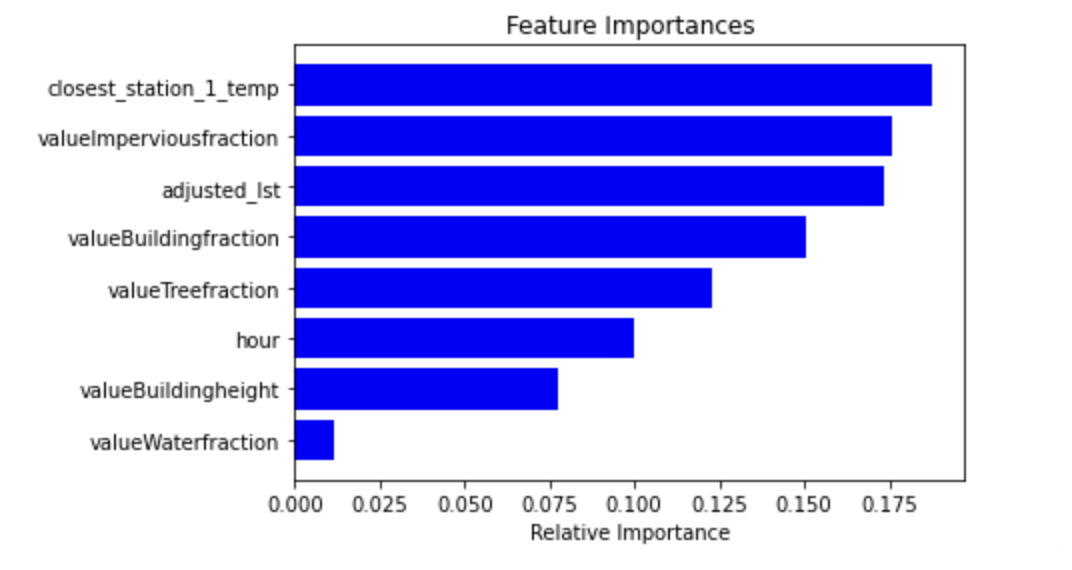
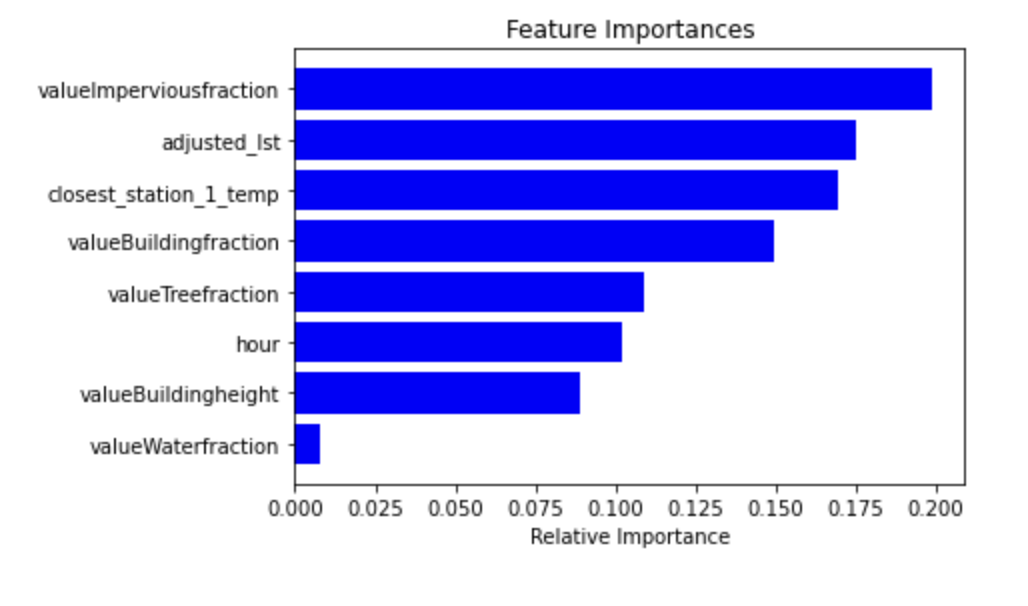

In [ ]:

month = 7
grouped_data = pd.read_csv(f'Analytics/temp_data/grouped_data_untouched_{month}.csv')


# Define the hyperparameter distributions
params = {
    'learning_rate': 0.1,  # Learning rate (shrinkage)
    'n_estimators': 300,  # Number of boosting stages
    'max_depth': 5,  # Maximum depth of the individual trees
    'subsample': 0.8,  # Fraction of samples used for fitting the trees (controls overfitting)
    'loss': 'squared_error',  # Least Squares regression
    # 'alpha': .99,  # L1 regularization term (only available in scikit-learn 0.24.0 and later)
    # 'ccp_alpha': 0.06
}

col_list = [
    # 'latitude', 'longitude', 
            'hour', 
            # 'closest_station_1_temp',
        #   'closest_1_distance',
      #  'day_of_year', 
    #    'adjusted_lst',
    #    'valueImperviousfraction',
         'valueTreefraction', 
        #  'valueBuildingheight',
      #  'valueNearestDistWater',
        #  'valueWaterfraction', 
         'valueBuildingfraction',
        #   'horizontal_wind','vertical_wind'
          ]

xgb_model = GBR(**params)
# xgb_model = xgb.XGBRegressor(**params)


model_dict = bulk_model_runner(xgb_model,grouped_data,col_list,bulk_mode=False,delete=True,residuals=True)
visualizer.plot_mean(model_dict,'GBR',col_list)


recent_folder = get_recent(MODEL_PATH)
model_name = get_recent(os.path.join(MODEL_PATH,recent_folder))
print(model_name)
global_dict7 = {}

hour_ranges = [0,9,12,15]
for hour in hour_ranges:
    predictor = predictor_oop.Predictor(model_name,hour_filter=[hour],wind_data=wind_status)
    #setting ec_data for this predictor to be only for that hour
    ec_segment = predictor.set_ec_segments(ec_data)
    runner_op = predictor.runner(urb_data,station_ranges)

    global_dict7[hour] = runner_op[0]

global_dict7['bound'] = runner_op[1]
global_dict7['test_column_list'] = runner_op[2]

hour_map = pd.read_csv(f'Analytics/temp_data/hour_lookup_{month}.csv')

for i in hour_ranges:
    global_dict7[i][0] += hour_map.to_dict()['old_temperature'][i]

for items in global_dict7:
    if items != 'bound' and items != 'test_column_list':
        visualizer.get_plot(global_dict7[items][0],global_dict7['bound'], cmap = 'coolwarm',change_null=True,plot_boundary=True,hour=items,model_name=predictor.model.__class__.__name__,dpi=600,save=False)



In [ ]:

month = 7
grouped_data = pd.read_csv(f'Analytics/temp_data/grouped_data_untouched_{month}.csv')


# Define the hyperparameter distributions
params = {
    'learning_rate': 0.1,  # Learning rate (shrinkage)
    'n_estimators': 300,  # Number of boosting stages
    'max_depth': 5,  # Maximum depth of the individual trees
    'subsample': 0.8,  # Fraction of samples used for fitting the trees (controls overfitting)
    'loss': 'squared_error',  # Least Squares regression
    # 'alpha': .99,  # L1 regularization term (only available in scikit-learn 0.24.0 and later)
    # 'ccp_alpha': 0.06
}

col_list = [
    # 'latitude', 'longitude', 
            'hour', 
            'closest_station_1_temp',
          'closest_1_distance',
      #  'day_of_year', 
       'adjusted_lst',
       'valueImperviousfraction', 'valueTreefraction', 'valueBuildingheight',
      #  'valueNearestDistWater',
         'valueWaterfraction', 'valueBuildingfraction',
        #   'horizontal_wind','vertical_wind'
          ]

xgb_model = GBR(**params)
# xgb_model = xgb.XGBRegressor(**params)


model_dict = bulk_model_runner(xgb_model,grouped_data,col_list,bulk_mode=False,delete=True,residuals=True)
visualizer.plot_mean(model_dict,'GBR',col_list)


recent_folder = get_recent(MODEL_PATH)
model_name = get_recent(os.path.join(MODEL_PATH,recent_folder))
print(model_name)
global_dict7 = {}

hour_ranges = [0,9]
for hour in hour_ranges:
    predictor = predictor_oop.Predictor(model_name,hour_filter=[hour],wind_data=wind_status)
    #setting ec_data for this predictor to be only for that hour
    ec_segment = predictor.set_ec_segments(ec_data)
    runner_op = predictor.runner(urb_data,station_ranges)

    global_dict7[hour] = runner_op[0]

global_dict7['bound'] = runner_op[1]
global_dict7['test_column_list'] = runner_op[2]

hour_map = pd.read_csv(f'Analytics/temp_data/hour_lookup_{month}.csv')

for i in hour_ranges:
    global_dict7[i][0] += hour_map.to_dict()['old_temperature'][i]

for items in global_dict7:
    if items != 'bound' and items != 'test_column_list':
        visualizer.get_plot(global_dict7[items][0],global_dict7['bound'], cmap = 'coolwarm',change_null=True,plot_boundary=True,hour=items,model_name=predictor.model.__class__.__name__,dpi=600,save=False)



In [ ]:
combine_results(global_dict1,global_dict4)

In [ ]:
combine_results(global_dict1,global_dict4)

In [ ]:

month = 7
grouped_data = pd.read_csv(f'Analytics/temp_data/grouped_data_filtered_{month}.csv')


# Define the hyperparameter distributions
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    # 'eta': 0.01,  # Learning rate (shrinkage)
    'eta': 0.03,  # Learning rate (shrinkage)
    # 'max_depth': 5,
    'lambda': 0.4,  # L2 regularization term
    'alpha': 0.4,  # L1 regularization term
}

col_list = [
    # 'latitude', 'longitude', 
            'hour', 
            'closest_station_1_temp',
          'closest_1_distance',
      #  'day_of_year', 
       'adjusted_lst',
       'valueImperviousfraction', 'valueTreefraction', 'valueBuildingheight',
      #  'valueNearestDistWater',
         'valueWaterfraction', 'valueBuildingfraction',
        #   'horizontal_wind','vertical_wind'
          ]


xgb_model = GBR()
# xgb_model = xgb.XGBRegressor(**params)

model_dict = bulk_model_runner(xgb_model,grouped_data,col_list,bulk_mode=False,delete=True,residuals=True)
visualizer.plot_mean(model_dict,'GBR',col_list)


recent_folder = get_recent(MODEL_PATH)
model_name = get_recent(os.path.join(MODEL_PATH,recent_folder))
print(model_name)
global_dict1 = {}

hour_ranges = range(24)
for hour in hour_ranges:
    predictor = predictor_oop.Predictor(model_name,hour_filter=[hour],wind_data=wind_status)
    #setting ec_data for this predictor to be only for that hour
    ec_segment = predictor.set_ec_segments(ec_data)
    runner_op = predictor.runner(urb_data,station_ranges)

    global_dict1[hour] = runner_op[0]

global_dict1['bound'] = runner_op[1]
global_dict1['test_column_list'] = runner_op[2]

hour_map = pd.read_csv(f'Analytics/temp_data/hour_lookup_{month}.csv')

for i in hour_ranges:
    global_dict1[i][0] += hour_map.to_dict()['old_temperature'][i]

for items in global_dict1:
    if items != 'bound' and items != 'test_column_list':
        visualizer.get_plot(global_dict1[items][0],global_dict1['bound'], cmap = 'coolwarm',change_null=True,plot_boundary=True,hour=items,model_name=predictor.model.__class__.__name__,dpi=600,save=False)



In [ ]:

month = 7
grouped_data = pd.read_csv(f'Analytics/temp_data/grouped_data_untouched_{month}.csv')


# Define the hyperparameter distributions
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    # 'eta': 0.01,  # Learning rate (shrinkage)
    'eta': 0.03,  # Learning rate (shrinkage)
    # 'max_depth': 5,
    'lambda': 0.4,  # L2 regularization term
    'alpha': 0.4,  # L1 regularization term
}

col_list = [
    # 'latitude', 'longitude', 
            'hour', 
            'closest_station_1_temp',
          'closest_1_distance',
      #  'day_of_year', 
       'adjusted_lst',
       'valueImperviousfraction', 'valueTreefraction', 'valueBuildingheight',
      #  'valueNearestDistWater',
         'valueWaterfraction', 'valueBuildingfraction',
        #   'horizontal_wind','vertical_wind'
          ]


xgb_model = GBR()
# xgb_model = xgb.XGBRegressor(**params)

model_dict = bulk_model_runner(xgb_model,grouped_data,col_list,bulk_mode=False,delete=True,residuals=True)
visualizer.plot_mean(model_dict,'GBR',col_list)


recent_folder = get_recent(MODEL_PATH)
model_name = get_recent(os.path.join(MODEL_PATH,recent_folder))
print(model_name)
global_dict2 = {}

hour_ranges = range(24)
for hour in hour_ranges:
    predictor = predictor_oop.Predictor(model_name,hour_filter=[hour],wind_data=wind_status)
    #setting ec_data for this predictor to be only for that hour
    ec_segment = predictor.set_ec_segments(ec_data)
    runner_op = predictor.runner(urb_data,station_ranges)

    global_dict2[hour] = runner_op[0]

global_dict2['bound'] = runner_op[1]
global_dict2['test_column_list'] = runner_op[2]

hour_map = pd.read_csv(f'Analytics/temp_data/hour_lookup_{month}.csv')

for i in hour_ranges:
    global_dict2[i][0] += hour_map.to_dict()['old_temperature'][i]

for items in global_dict2:
    if items != 'bound' and items != 'test_column_list':
        visualizer.get_plot(global_dict2[items][0],global_dict2['bound'], cmap = 'coolwarm',change_null=True,plot_boundary=True,hour=items,model_name=predictor.model.__class__.__name__,dpi=600,save=False)



In [ ]:
combine_results(global_dict1,global_dict2)

In [ ]:

month = 7
grouped_data = pd.read_csv(f'Analytics/temp_data/grouped_data_filtered_{month}.csv')


# Define the hyperparameter distributions
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    # 'eta': 0.01,  # Learning rate (shrinkage)
    'eta': 0.03,  # Learning rate (shrinkage)
    # 'max_depth': 5,
    'lambda': 0.4,  # L2 regularization term
    'alpha': 0.4,  # L1 regularization term
}

col_list = [
    # 'latitude', 'longitude', 
            'hour', 
            'closest_station_1_temp',
        #   'closest_1_distance',
      #  'day_of_year', 
       'adjusted_lst',
       'valueImperviousfraction', 'valueTreefraction', 'valueBuildingheight',
      #  'valueNearestDistWater',
         'valueWaterfraction', 'valueBuildingfraction',
        #   'horizontal_wind','vertical_wind'
          ]


xgb_model = GBR()
# xgb_model = xgb.XGBRegressor(**params)

model_dict = bulk_model_runner(xgb_model,grouped_data,col_list,bulk_mode=False,delete=True,residuals=True)
visualizer.plot_mean(model_dict,'GBR',col_list)


recent_folder = get_recent(MODEL_PATH)
model_name = get_recent(os.path.join(MODEL_PATH,recent_folder))
print(model_name)
global_dict11 = {}

hour_ranges = range(24)
for hour in hour_ranges:
    predictor = predictor_oop.Predictor(model_name,hour_filter=[hour],wind_data=wind_status)
    #setting ec_data for this predictor to be only for that hour
    ec_segment = predictor.set_ec_segments(ec_data)
    runner_op = predictor.runner(urb_data,station_ranges)

    global_dict11[hour] = runner_op[0]

global_dict11['bound'] = runner_op[1]
global_dict11['test_column_list'] = runner_op[2]

hour_map = pd.read_csv(f'Analytics/temp_data/hour_lookup_{month}.csv')

for i in hour_ranges:
    global_dict11[i][0] += hour_map.to_dict()['old_temperature'][i]

for items in global_dict11:
    if items != 'bound' and items != 'test_column_list':
        visualizer.get_plot(global_dict11[items][0],global_dict11['bound'], cmap = 'coolwarm',change_null=True,plot_boundary=True,hour=items,model_name=predictor.model.__class__.__name__,dpi=600,save=False)



In [ ]:

month = 7
grouped_data = pd.read_csv(f'Analytics/temp_data/grouped_data_untouched_{month}.csv')


# Define the hyperparameter distributions
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    # 'eta': 0.01,  # Learning rate (shrinkage)
    'eta': 0.03,  # Learning rate (shrinkage)
    # 'max_depth': 5,
    'lambda': 0.4,  # L2 regularization term
    'alpha': 0.4,  # L1 regularization term
}

col_list = [
    # 'latitude', 'longitude', 
            'hour', 
            'closest_station_1_temp',
        #   'closest_1_distance',
      #  'day_of_year', 
       'adjusted_lst',
       'valueImperviousfraction', 'valueTreefraction', 'valueBuildingheight',
      #  'valueNearestDistWater',
         'valueWaterfraction', 'valueBuildingfraction',
        #   'horizontal_wind','vertical_wind'
          ]


xgb_model = GBR()
# xgb_model = xgb.XGBRegressor(**params)

model_dict = bulk_model_runner(xgb_model,grouped_data,col_list,bulk_mode=False,delete=True,residuals=True)
visualizer.plot_mean(model_dict,'GBR',col_list)


recent_folder = get_recent(MODEL_PATH)
model_name = get_recent(os.path.join(MODEL_PATH,recent_folder))
print(model_name)
global_dict22 = {}

hour_ranges = range(24)
for hour in hour_ranges:
    predictor = predictor_oop.Predictor(model_name,hour_filter=[hour],wind_data=wind_status)
    #setting ec_data for this predictor to be only for that hour
    ec_segment = predictor.set_ec_segments(ec_data)
    runner_op = predictor.runner(urb_data,station_ranges)

    global_dict22[hour] = runner_op[0]

global_dict22['bound'] = runner_op[1]
global_dict22['test_column_list'] = runner_op[2]

hour_map = pd.read_csv(f'Analytics/temp_data/hour_lookup_{month}.csv')

for i in hour_ranges:
    global_dict22[i][0] += hour_map.to_dict()['old_temperature'][i]

for items in global_dict22:
    if items != 'bound' and items != 'test_column_list':
        visualizer.get_plot(global_dict22[items][0],global_dict22['bound'], cmap = 'coolwarm',change_null=True,plot_boundary=True,hour=items,model_name=predictor.model.__class__.__name__,dpi=600,save=False)



In [ ]:
combine_results(global_dict11,global_dict22)

In [ ]:

month = 8
grouped_data = pd.read_csv(f'Analytics/temp_data/grouped_data_filtered_{month}.csv')


# Define the hyperparameter distributions
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    # 'eta': 0.01,  # Learning rate (shrinkage)
    'eta': 0.03,  # Learning rate (shrinkage)
    # 'max_depth': 5,
    'lambda': 0.4,  # L2 regularization term
    'alpha': 0.4,  # L1 regularization term
}

col_list = [
    # 'latitude', 'longitude', 
            'hour', 
            'closest_station_1_temp',
        #   'closest_1_distance',
      #  'day_of_year', 
       'adjusted_lst',
       'valueImperviousfraction', 'valueTreefraction', 'valueBuildingheight',
      #  'valueNearestDistWater',
         'valueWaterfraction', 'valueBuildingfraction',
        #   'horizontal_wind','vertical_wind'
          ]


xgb_model = GBR()
# xgb_model = xgb.XGBRegressor(**params)

model_dict = bulk_model_runner(xgb_model,grouped_data,col_list,bulk_mode=False,delete=True,residuals=True)
visualizer.plot_mean(model_dict,'GBR',col_list)


recent_folder = get_recent(MODEL_PATH)
model_name = get_recent(os.path.join(MODEL_PATH,recent_folder))
print(model_name)
global_dict81 = {}

hour_ranges = range(24)
for hour in hour_ranges:
    predictor = predictor_oop.Predictor(model_name,hour_filter=[hour],wind_data=wind_status)
    #setting ec_data for this predictor to be only for that hour
    ec_segment = predictor.set_ec_segments(ec_data)
    runner_op = predictor.runner(urb_data,station_ranges)

    global_dict81[hour] = runner_op[0]

global_dict81['bound'] = runner_op[1]
global_dict81['test_column_list'] = runner_op[2]

hour_map = pd.read_csv(f'Analytics/temp_data/hour_lookup_{month}.csv')

for i in hour_ranges:
    global_dict81[i][0] += hour_map.to_dict()['old_temperature'][i]

# for items in global_dict81:
#     if items != 'bound' and items != 'test_column_list':
#         visualizer.get_plot(global_dict81[items][0],global_dict81['bound'], cmap = 'coolwarm',change_null=True,plot_boundary=True,hour=items,model_name=predictor.model.__class__.__name__,dpi=600,save=False)


month = 8
grouped_data = pd.read_csv(f'Analytics/temp_data/grouped_data_untouched_{month}.csv')


# Define the hyperparameter distributions
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    # 'eta': 0.01,  # Learning rate (shrinkage)
    'eta': 0.03,  # Learning rate (shrinkage)
    # 'max_depth': 5,
    'lambda': 0.4,  # L2 regularization term
    'alpha': 0.4,  # L1 regularization term
}

col_list = [
    # 'latitude', 'longitude', 
            'hour', 
            'closest_station_1_temp',
        #   'closest_1_distance',
      #  'day_of_year', 
       'adjusted_lst',
       'valueImperviousfraction', 'valueTreefraction', 'valueBuildingheight',
      #  'valueNearestDistWater',
         'valueWaterfraction', 'valueBuildingfraction',
        #   'horizontal_wind','vertical_wind'
          ]


xgb_model = GBR()
# xgb_model = xgb.XGBRegressor(**params)

model_dict = bulk_model_runner(xgb_model,grouped_data,col_list,bulk_mode=False,delete=True,residuals=True)
visualizer.plot_mean(model_dict,'GBR',col_list)


recent_folder = get_recent(MODEL_PATH)
model_name = get_recent(os.path.join(MODEL_PATH,recent_folder))
print(model_name)
global_dict82 = {}

hour_ranges = range(24)
for hour in hour_ranges:
    predictor = predictor_oop.Predictor(model_name,hour_filter=[hour],wind_data=wind_status)
    #setting ec_data for this predictor to be only for that hour
    ec_segment = predictor.set_ec_segments(ec_data)
    runner_op = predictor.runner(urb_data,station_ranges)

    global_dict82[hour] = runner_op[0]

global_dict82['bound'] = runner_op[1]
global_dict82['test_column_list'] = runner_op[2]

hour_map = pd.read_csv(f'Analytics/temp_data/hour_lookup_{month}.csv')

for i in hour_ranges:
    global_dict82[i][0] += hour_map.to_dict()['old_temperature'][i]

# for items in global_dict82:
#     if items != 'bound' and items != 'test_column_list':
#         visualizer.get_plot(global_dict82[items][0],global_dict82['bound'], cmap = 'coolwarm',change_null=True,plot_boundary=True,hour=items,model_name=predictor.model.__class__.__name__,dpi=600,save=False)



In [ ]:
combine_results(global_dict81,global_dict82)

In [ ]:

month = 8
grouped_data = pd.read_csv(f'Analytics/temp_data/grouped_data_filtered_{month}.csv')


# Define the hyperparameter distributions
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    # 'eta': 0.01,  # Learning rate (shrinkage)
    'eta': 0.03,  # Learning rate (shrinkage)
    # 'max_depth': 5,
    'lambda': 0.4,  # L2 regularization term
    'alpha': 0.4,  # L1 regularization term
}

col_list = [
    # 'latitude', 'longitude', 
            'hour', 
            'closest_station_1_temp',
          'closest_1_distance',
      #  'day_of_year', 
       'adjusted_lst',
       'valueImperviousfraction', 'valueTreefraction', 'valueBuildingheight',
      #  'valueNearestDistWater',
         'valueWaterfraction', 'valueBuildingfraction',
        #   'horizontal_wind','vertical_wind'
          ]


xgb_model = GBR()
# xgb_model = xgb.XGBRegressor(**params)

model_dict = bulk_model_runner(xgb_model,grouped_data,col_list,bulk_mode=False,delete=True,residuals=True)
visualizer.plot_mean(model_dict,'GBR',col_list)


recent_folder = get_recent(MODEL_PATH)
model_name = get_recent(os.path.join(MODEL_PATH,recent_folder))
print(model_name)
global_dict83 = {}

hour_ranges = range(24)
for hour in hour_ranges:
    predictor = predictor_oop.Predictor(model_name,hour_filter=[hour],wind_data=wind_status)
    #setting ec_data for this predictor to be only for that hour
    ec_segment = predictor.set_ec_segments(ec_data)
    runner_op = predictor.runner(urb_data,station_ranges)

    global_dict83[hour] = runner_op[0]

global_dict83['bound'] = runner_op[1]
global_dict83['test_column_list'] = runner_op[2]

hour_map = pd.read_csv(f'Analytics/temp_data/hour_lookup_{month}.csv')

for i in hour_ranges:
    global_dict83[i][0] += hour_map.to_dict()['old_temperature'][i]

# for items in global_dict83:
#     if items != 'bound' and items != 'test_column_list':
#         visualizer.get_plot(global_dict83[items][0],global_dict83['bound'], cmap = 'coolwarm',change_null=True,plot_boundary=True,hour=items,model_name=predictor.model.__class__.__name__,dpi=600,save=False)


month = 8
grouped_data = pd.read_csv(f'Analytics/temp_data/grouped_data_untouched_{month}.csv')


# Define the hyperparameter distributions
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    # 'eta': 0.01,  # Learning rate (shrinkage)
    'eta': 0.03,  # Learning rate (shrinkage)
    # 'max_depth': 5,
    'lambda': 0.4,  # L2 regularization term
    'alpha': 0.4,  # L1 regularization term
}

col_list = [
    # 'latitude', 'longitude', 
            'hour', 
            'closest_station_1_temp',
          'closest_1_distance',
      #  'day_of_year', 
       'adjusted_lst',
       'valueImperviousfraction', 'valueTreefraction', 'valueBuildingheight',
      #  'valueNearestDistWater',
         'valueWaterfraction', 'valueBuildingfraction',
        #   'horizontal_wind','vertical_wind'
          ]


xgb_model = GBR()
# xgb_model = xgb.XGBRegressor(**params)

model_dict = bulk_model_runner(xgb_model,grouped_data,col_list,bulk_mode=False,delete=True,residuals=True)
visualizer.plot_mean(model_dict,'GBR',col_list)


recent_folder = get_recent(MODEL_PATH)
model_name = get_recent(os.path.join(MODEL_PATH,recent_folder))
print(model_name)
global_dict84 = {}

hour_ranges = range(24)
for hour in hour_ranges:
    predictor = predictor_oop.Predictor(model_name,hour_filter=[hour],wind_data=wind_status)
    #setting ec_data for this predictor to be only for that hour
    ec_segment = predictor.set_ec_segments(ec_data)
    runner_op = predictor.runner(urb_data,station_ranges)

    global_dict84[hour] = runner_op[0]

global_dict84['bound'] = runner_op[1]
global_dict84['test_column_list'] = runner_op[2]

hour_map = pd.read_csv(f'Analytics/temp_data/hour_lookup_{month}.csv')

for i in hour_ranges:
    global_dict84[i][0] += hour_map.to_dict()['old_temperature'][i]

# for items in global_dict84:
#     if items != 'bound' and items != 'test_column_list':
#         visualizer.get_plot(global_dict84[items][0],global_dict84['bound'], cmap = 'coolwarm',change_null=True,plot_boundary=True,hour=items,model_name=predictor.model.__class__.__name__,dpi=600,save=False)



In [ ]:
combine_results(global_dict83,global_dict84,cmap='plasma')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# Assuming you have the following data
# Replace this with your actual data
pixel_coordinates = np.array([[x, y] for x in range(width) for y in range(height)])
pixel_temperatures = np.array([your_pixel_temperature_values])

# Define the desired grid for the temperature map
grid_x, grid_y = np.mgrid[0:width, 0:height]

# Use griddata to perform interpolation
smooth_temperatures = griddata(pixel_coordinates, pixel_temperatures, (grid_x, grid_y), method='cubic')

# Plot the original and smooth temperature maps
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(pixel_temperatures.reshape((width, height)), cmap='viridis', origin='lower')
plt.title('Original Temperature Map')

plt.subplot(1, 2, 2)
plt.imshow(smooth_temperatures.T, cmap='viridis', origin='lower')
plt.title('Smoothed Temperature Map')

plt.show()

In [ ]:
len(global_dict83[0][0].reshape(-1,1))

In [ ]:
station = pd.read_csv('Analytics/station_list.csv')
station = station[['latitude','longitude','prediction_temps']]

In [ ]:
station = station.iloc[:len(global_dict83[0][0].reshape(-1,1))]
station.prediction_temps = global_dict83[0][0].reshape(-1,1)

In [ ]:
from scipy.interpolate import griddata

width = 10
height = 10

pixel_coordinates = np.array([[x, y] for x in range(width) for y in range(height)])
pixel_temperatures = np.array([station.prediction_temps])

# Define the desired grid for the temperature map
grid_x, grid_y = np.mgrid[0:width, 0:height]

# Use griddata to perform interpolation
# smooth_temperatures = griddata(pixel_coordinates, pixel_temperatures, (grid_x, grid_y), method='cubic')

# # Plot the original and smooth temperature maps
# plt.figure(figsize=(12, 6))

# plt.subplot(1, 2, 1)
# plt.imshow(pixel_temperatures.reshape((width, height)), cmap='viridis', origin='lower')
# plt.title('Original Temperature Map')

# plt.subplot(1, 2, 2)
# plt.imshow(smooth_temperatures.T, cmap='viridis', origin='lower')
# plt.title('Smoothed Temperature Map')

# plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# Generating random pixel data
np.random.seed(42)
width, height = 10, 7
pixel_coordinates = np.array([[x, y] for x in range(width) for y in range(height)])
pixel_temperatures = np.random.uniform(20, 30, width * height)

# Define the desired grid for the temperature map
grid_x, grid_y = np.mgrid[0:width, 0:height]

# Use griddata to perform cubic interpolation
smooth_temperatures = griddata(pixel_coordinates, pixel_temperatures, (grid_x, grid_y), method='cubic')

# Plot the original and smooth temperature maps
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(pixel_temperatures.reshape((width, height)), cmap='viridis', origin='lower')
plt.title('Original Temperature Map')

plt.subplot(1, 2, 2)
plt.imshow(smooth_temperatures.T, cmap='viridis', origin='lower')
plt.title('Smoothed Temperature Map')

plt.show()


In [2]:
len(station.prediction_temps.iloc[:100])

NameError: name 'station' is not defined

In [2]:
from sklearn.ensemble import GradientBoostingRegressor as GBR
month = 6
grouped_data = pd.read_csv(f'Analytics/temp_data/grouped_data_filtered_{month}.csv')


# Define the hyperparameter distributions
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    # 'eta': 0.01,  # Learning rate (shrinkage)
    'eta': 0.03,  # Learning rate (shrinkage)
    # 'max_depth': 5,
    'lambda': 0.4,  # L2 regularization term
    'alpha': 0.4,  # L1 regularization term
}

col_list = [
    # 'latitude', 'longitude', 
            'hour', 
            # 'closest_station_1_temp',
        #   'closest_1_distance',
      #  'day_of_year', 
    #    'adjusted_lst',
    #    'valueImperviousfraction', 'valueTreefraction', 'valueBuildingheight',
      #  'valueNearestDistWater',
        #  'valueWaterfraction', 'valueBuildingfraction',
        #   'horizontal_wind','vertical_wind'
          ]


xgb_model = GBR()
# xgb_model = xgb.XGBRegressor(**params)

model_dict = bulk_model_runner(xgb_model,grouped_data,col_list,bulk_mode=False,delete=True,residuals=True)
visualizer.plot_mean(model_dict,'GBR',col_list)


recent_folder = get_recent(MODEL_PATH)
model_name = get_recent(os.path.join(MODEL_PATH,recent_folder))
print(model_name)
global_dictn = {}

hour_ranges = [0,1]
for hour in hour_ranges:
    predictor = predictor_oop.Predictor(model_name,hour_filter=[hour],wind_data=False)
    #setting ec_data for this predictor to be only for that hour
    ec_segment = predictor.set_ec_segments(ec_data)
    runner_op = predictor.runner(urb_data,station_ranges)

    global_dictn[hour] = runner_op[0]

global_dictn['bound'] = runner_op[1]
global_dictn['test_column_list'] = runner_op[2]

hour_map = pd.read_csv(f'Analytics/temp_data/hour_lookup_{month}.csv')

for i in hour_ranges:
    global_dictn[i][0] += hour_map.to_dict()['old_temperature'][i]

for items in global_dictn:
    if items != 'bound' and items != 'test_column_list':
        visualizer.get_plot(global_dictn[items][0],global_dictn['bound'], cmap = 'coolwarm',change_null=True,plot_boundary=True,hour=items,model_name=predictor.model.__class__.__name__,dpi=600,save=False)



NameError: name 'bulk_model_runner' is not defined